# Лабораторная работа №2. Задача классификации

**Тема:** *Анализ и сравнение разных классификаторов*

**Цели:**

- *Научиться обрабатывать датасет*
- *Реализовать разные классификаторы*
- *Понять, как интерпретировать важность признаков (feature importance)*
- *Понять, как увеличивать кол-во признаков (feature tuning)*


**Модели:**

- *Линейная регрессия*
- *Метод опорных векторов (SVM)*
- *$K$ - ближайших соседей*
- *Дерево решений*
- *Случайный лес*
- *Градиентный бустинг*


#### 👋🏻 ЧТО НУЖНО СДЕЛАТЬ СТУДЕНТАМ ???

1. Загрузить датасет, который был в `lr_1.ipynb`
2. Свести его к задаче классификации (бинарной или многоклассовой).
3. Обработать датасет
4. Обучить модели
5. (команда) Реализовать свою логистическую регрессию. Настроить параметр вероятности ответа как if $ y_{pred} < 0,5$ then $0$ else $1$ чтобы получилась бинарная классификация
6. **(необезательно, но можно получить плюсик от меня)** С помощью `optuna` реализовать подгонку гиперпараметров для `CatBoost`.
7. Ответить на вопросы
8. Придумать какую-то уникальность работы, то, что будет вас отличать от других, и это вам надо будет мне "продать".
8. Составить `презентацию` о проделанной работе (10-15 слайдов), а именно: нужно выбрать одну модель, и для нее описать подготовку датасета, распределение данных, показать какие метрики выдает модель при разных настройках, побольше описательных графиков. Вам нужно будет мне "продавть ваше решение".
9. Записать `видео вашей защиты на 5 минут`, где вы рассказываете только о вашей фиче.

#### Форматы сдачи

1. Один студент, делает только стандартные реализации. Упрощенная форма сдачи.
2. Команда из 2х людей. Нужно обязательно сделать Логистическую регрессию и сравнить ее с лучшей стандартной моделью.
3. Команда из 3х людей. Сделать то, что и в команде из 2х человек + обязательно реализация подбора гиперпараметров, с помощью Optuna.

#### Как получить дополнительные плюсики

Я буду оценивать вашу работу комплексно, т.к. нас `55 человек`, то:
1. Самую лучшую работу, сданную на 5, буду расценивать за 6 плюсиков. Если вы в соло делаете, это большое преимущество, 6 баллов ваши, если командой, то делится на команду.
2. 5 человек получат по 2 плюсика
3. 10 человек получат по 1 плюсику

#### Дедлайны

- До 24.10.25 argmax(оценки) = 5 (есть возможность на +)
- До 31.10.25 argmax(оценки) = 4 (нет возможности на +)
- До 07.11.25 argmax(оценки) = 3 (нет возможности на +)

## 1. Введение

Цель: загрузить датасет, сделать описание и сформулировать задачу

### 1.0. Испортируем библиотеки и зафиксируем случайность

In [561]:
# Main libs for data
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import StandardScaler

In [562]:
# Project Settings
RANDOM_STATE = 42

### 1.1. Загрузка датасета

In [563]:
# read data and check values
file_path = Path('student_habits_performance.csv')
df_raw = pd.read_csv(file_path)
df_raw.head(3)


student_id  age  gender  study_hours_per_day  social_media_hours  \
0      S1000   23  Female                  0.0                 1.2   
1      S1001   20  Female                  6.9                 2.8   
2      S1002   21    Male                  1.4                 3.1   

   netflix_hours part_time_job  attendance_percentage  sleep_hours  \
0            1.1            No                   85.0          8.0   
1            2.3            No                   97.3          4.6   
2            1.3            No                   94.8          8.0   

  diet_quality  exercise_frequency parental_education_level internet_quality  \
0         Fair                   6                   Master          Average   
1         Good                   6              High School          Average   
2         Poor                   1              High School             Poor   

   mental_health_rating extracurricular_participation  exam_score  
0                     8                           Yes        56.2  
1                     8                            No       100.0  
2                     1                            No        34.3

Видно, что столбец `Id` не несет никакой смысловой нагрузки

In [564]:
if 'student_id' in df_raw.columns:
    df_raw = df_raw.drop(columns=['student_id'])
    
df_raw.head(3)

age  gender  study_hours_per_day  social_media_hours  netflix_hours  \
0   23  Female                  0.0                 1.2            1.1   
1   20  Female                  6.9                 2.8            2.3   
2   21    Male                  1.4                 3.1            1.3   

  part_time_job  attendance_percentage  sleep_hours diet_quality  \
0            No                   85.0          8.0         Fair   
1            No                   97.3          4.6         Good   
2            No                   94.8          8.0         Poor   

   exercise_frequency parental_education_level internet_quality  \
0                   6                   Master          Average   
1                   6              High School          Average   
2                   1              High School             Poor   

   mental_health_rating extracurricular_participation  exam_score  
0                     8                           Yes        56.2  
1                     8                            No       100.0  
2                     1                            No        34.3

In [565]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1000 non-null   int64  
 1   gender                         1000 non-null   object 
 2   study_hours_per_day            1000 non-null   float64
 3   social_media_hours             1000 non-null   float64
 4   netflix_hours                  1000 non-null   float64
 5   part_time_job                  1000 non-null   object 
 6   attendance_percentage          1000 non-null   float64
 7   sleep_hours                    1000 non-null   float64
 8   diet_quality                   1000 non-null   object 
 9   exercise_frequency             1000 non-null   int64  
 10  parental_education_level       909 non-null    object 
 11  internet_quality               1000 non-null   object 
 12  mental_health_rating           1000 non-null   in

### 1.2. Поставновка задачи

**Целевая задача:**  классическая задача классификации результатов экзамена студентов. Мы можем решить её как:
- **Мультиклассовая классификация** (каждый диапазон баллов — отдельный класс, например, 0-2, 3-5, 6-7, 8-10)
- **Бинарная классификация** (например, плохой результат vs хороший, порог балла >= 6 как "хорошо").


## 2. Подготовка данных

### 2.0. Предварительный анализ данных

Типы признаков

In [566]:
print(f'Типы признаков:\n{df_raw.dtypes}')

Типы признаков:
age                                int64
gender                            object
study_hours_per_day              float64
social_media_hours               float64
netflix_hours                    float64
part_time_job                     object
attendance_percentage            float64
sleep_hours                      float64
diet_quality                      object
exercise_frequency                 int64
parental_education_level          object
internet_quality                  object
mental_health_rating               int64
extracurricular_participation     object
exam_score                       float64
dtype: object


In [567]:
print(f'Пропуски данных:\n{df_raw.isna().sum()}')

Пропуски данных:
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64


В датасете 91 пропуск в parental_education_level. Заменим их самым часто встречающимся значением

In [568]:
na_cols = df_raw.columns[df_raw.isna().any()].tolist()
for col in na_cols:
    mode_vals = df_raw[col].mode(dropna=True)
    if not mode_vals.empty:
        df_raw[col] = df_raw[col].fillna(mode_vals[0])

print(df_raw.isnull().sum())

age                              0
gender                           0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
exam_score                       0
dtype: int64


В датасете  признаки имеют тип `float64, int64, object`, приведем все типы к числам

In [569]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for column in df_raw.columns:
    if df_raw[column].dtype == object:
        le = LabelEncoder()
        df_raw[column] = le.fit_transform(df_raw[column])
        label_encoders[column] = le
print(f'Типы признаков после кодирования:\n{df_raw.dtypes}')

Типы признаков после кодирования:
age                                int64
gender                             int64
study_hours_per_day              float64
social_media_hours               float64
netflix_hours                    float64
part_time_job                      int64
attendance_percentage            float64
sleep_hours                      float64
diet_quality                       int64
exercise_frequency                 int64
parental_education_level           int64
internet_quality                   int64
mental_health_rating               int64
extracurricular_participation      int64
exam_score                       float64
dtype: object


In [570]:
print('Базовая статистика в удобном виде:')
df_raw.describe().T

Базовая статистика в удобном виде:


count     mean        std   min     25%   50%  \
age                            1000.0  20.4980   2.308100  17.0  18.750  20.0   
gender                         1000.0   0.5610   0.574987   0.0   0.000   1.0   
study_hours_per_day            1000.0   3.5501   1.468890   0.0   2.600   3.5   
social_media_hours             1000.0   2.5055   1.172422   0.0   1.700   2.5   
netflix_hours                  1000.0   1.8197   1.075118   0.0   1.000   1.8   
part_time_job                  1000.0   0.2150   0.411028   0.0   0.000   0.0   
attendance_percentage          1000.0  84.1317   9.399246  56.0  78.000  84.4   
sleep_hours                    1000.0   6.4701   1.226377   3.2   5.600   6.5   
diet_quality                   1000.0   0.7480   0.747700   0.0   0.000   1.0   
exercise_frequency             1000.0   3.0420   2.025423   0.0   1.000   3.0   
parental_education_level       1000.0   0.8170   0.695697   0.0   0.000   1.0   
internet_quality               1000.0   0.7710   0.707856   0.0   0.000   1.0   
mental_health_rating           1000.0   5.4380   2.847501   1.0   3.000   5.0   
extracurricular_participation  1000.0   0.3180   0.465932   0.0   0.000   0.0   
exam_score                     1000.0  69.6015  16.888564  18.4  58.475  70.5   

                                  75%    max  
age                            23.000   24.0  
gender                          1.000    2.0  
study_hours_per_day             4.500    8.3  
social_media_hours              3.300    7.2  
netflix_hours                   2.525    5.4  
part_time_job                   0.000    1.0  
attendance_percentage          91.025  100.0  
sleep_hours                     7.300   10.0  
diet_quality                    1.000    2.0  
exercise_frequency              5.000    6.0  
parental_education_level        1.000    2.0  
internet_quality                1.000    2.0  
mental_health_rating            8.000   10.0  
extracurricular_participation   1.000    1.0  
exam_score                     81.325  100.0

По базовой статистике видно, что у некоторых фичей есть скос и выбросы.

### 2.1. Feauture Engineering

**Соотношение учебных и отвлекающих активностей**

Показывает, насколько студент больше учится, чем тратит время на соцсети и Netflix

In [571]:
if 'study_to_leisure_ratio' not in df_raw.columns:
    df_raw['study_to_leisure_ratio'] = df_raw['study_hours_per_day'] / (df_raw['social_media_hours'] + df_raw['netflix_hours'] + 1e-3)

df_raw[['study_hours_per_day', 'social_media_hours', 'netflix_hours', 'study_to_leisure_ratio']].head(4)

study_hours_per_day  social_media_hours  netflix_hours  \
0                  0.0                 1.2            1.1   
1                  6.9                 2.8            2.3   
2                  1.4                 3.1            1.3   
3                  1.0                 3.9            1.0   

   study_to_leisure_ratio  
0                0.000000  
1                1.352676  
2                0.318110  
3                0.204040

**Эффективность сна**

Здоровый сон влияет на когнитивные функции. Проверим эффект сна относительно учебных часов.

In [572]:
if 'sleep_efficiency' not in df_raw.columns:
    df_raw['sleep_efficiency'] = df_raw['sleep_hours'] / (df_raw['study_hours_per_day'] + 1e-3)

df_raw[['sleep_hours', 'study_hours_per_day', 'sleep_efficiency']].head(4)

sleep_hours  study_hours_per_day  sleep_efficiency
0          8.0                  0.0       8000.000000
1          4.6                  6.9          0.666570
2          8.0                  1.4          5.710207
3          9.2                  1.0          9.190809

**Активность и физическое здоровье**

Спорт и питание — показатели общего состояния. Создадим агрегированную фичу.

In [573]:
if 'health_index' not in df_raw.columns:
    df_raw['health_index'] = (df_raw['exercise_frequency'] + df_raw['diet_quality'] + df_raw['mental_health_rating']) / 3

df_raw[['exercise_frequency', 'diet_quality', 'mental_health_rating', 'health_index']].head(4)


exercise_frequency  diet_quality  mental_health_rating  health_index
0                   6             0                     8      4.666667
1                   6             1                     8      5.000000
2                   1             2                     1      1.333333
3                   4             2                     1      2.333333

**Посещаемость и вовлеченность**

Добавим взвешенную метрику, учитывающую участие во внеучебных активностях

In [574]:
if 'engagement_score' not in df_raw.columns:
    df_raw['engagement_score'] = df_raw['attendance_percentage'] * (1 + df_raw['extracurricular_participation'])

df_raw[['attendance_percentage', 'extracurricular_participation', 'engagement_score']].head(4)

attendance_percentage  extracurricular_participation  engagement_score
0                   85.0                              1             170.0
1                   97.3                              0              97.3
2                   94.8                              0              94.8
3                   71.0                              1             142.0

**Учебная нагрузка на возраст**

Показывает зрелость и дисциплину — старшие студенты могут эффективнее использовать учебное время.

In [575]:
if 'study_age_ratio' not in df_raw.columns:
    df_raw['study_age_ratio'] = df_raw['study_hours_per_day'] / df_raw['age']

df_raw[['age', 'study_hours_per_day', 'study_age_ratio']].head(4)

age  study_hours_per_day  study_age_ratio
0   23                  0.0         0.000000
1   20                  6.9         0.345000
2   21                  1.4         0.066667
3   23                  1.0         0.043478

**Логарифм количества часов в соцсетях**

Распределение может быть скошенным, поэтому применим логарифм для стабилизации

In [576]:
if 'log_social_media' not in df_raw.columns:
    df_raw['log_social_media'] = np.log(df_raw['social_media_hours'] + 1)

df_raw[['social_media_hours', 'log_social_media']].head(4)

social_media_hours  log_social_media
0                 1.2          0.788457
1                 2.8          1.335001
2                 3.1          1.410987
3                 3.9          1.589235

**Интерактивные признаки**

Комбинируем здоровье и вовлеченность: здоровый и активный студент с хорошей посещаемостью

In [577]:
if 'active_health_ratio' not in df_raw.columns:
    df_raw['active_health_ratio'] = df_raw['health_index'] * (df_raw['engagement_score'] / 100)

df_raw[['health_index', 'engagement_score', 'active_health_ratio']].head(4)

health_index  engagement_score  active_health_ratio
0      4.666667             170.0             7.933333
1      5.000000              97.3             4.865000
2      1.333333              94.8             1.264000
3      2.333333             142.0             3.313333

**Баланс учебы и отдыха**

Отношение сна и соцсетей показывает баланс между отдыхом и развлечениями

In [578]:
if 'rest_balance' not in df_raw.columns:
    df_raw['rest_balance'] = df_raw['sleep_hours'] / (df_raw['social_media_hours'] + df_raw['netflix_hours'] + 1e-3)

df_raw[['sleep_hours', 'social_media_hours', 'netflix_hours', 'rest_balance']].head(4)

sleep_hours  social_media_hours  netflix_hours  rest_balance
0          8.0                 1.2            1.1      3.476749
1          4.6                 2.8            2.3      0.901784
2          8.0                 3.1            1.3      1.817769
3          9.2                 3.9            1.0      1.877168

In [579]:
print(f'Итого признаков после Feature Engineering: {df_raw.shape[1]}')

Итого признаков после Feature Engineering: 23


Итого у нас получилось (24 фичи)

In [580]:
df_raw.head(3)

age  gender  study_hours_per_day  social_media_hours  netflix_hours  \
0   23       0                  0.0                 1.2            1.1   
1   20       0                  6.9                 2.8            2.3   
2   21       1                  1.4                 3.1            1.3   

   part_time_job  attendance_percentage  sleep_hours  diet_quality  \
0              0                   85.0          8.0             0   
1              0                   97.3          4.6             1   
2              0                   94.8          8.0             2   

   exercise_frequency  ...  extracurricular_participation  exam_score  \
0                   6  ...                              1        56.2   
1                   6  ...                              0       100.0   
2                   1  ...                              0        34.3   

   study_to_leisure_ratio  sleep_efficiency  health_index  engagement_score  \
0                0.000000       8000.000000      4.666667             170.0   
1                1.352676          0.666570      5.000000              97.3   
2                0.318110          5.710207      1.333333              94.8   

   study_age_ratio  log_social_media  active_health_ratio  rest_balance  
0         0.000000          0.788457             7.933333      3.476749  
1         0.345000          1.335001             4.865000      0.901784  
2         0.066667          1.410987             1.264000      1.817769  

[3 rows x 23 columns]

In [581]:
df_raw.describe().T

count        mean         std        min  \
age                            1000.0   20.498000    2.308100  17.000000   
gender                         1000.0    0.561000    0.574987   0.000000   
study_hours_per_day            1000.0    3.550100    1.468890   0.000000   
social_media_hours             1000.0    2.505500    1.172422   0.000000   
netflix_hours                  1000.0    1.819700    1.075118   0.000000   
part_time_job                  1000.0    0.215000    0.411028   0.000000   
attendance_percentage          1000.0   84.131700    9.399246  56.000000   
sleep_hours                    1000.0    6.470100    1.226377   3.200000   
diet_quality                   1000.0    0.748000    0.747700   0.000000   
exercise_frequency             1000.0    3.042000    2.025423   0.000000   
parental_education_level       1000.0    0.817000    0.695697   0.000000   
internet_quality               1000.0    0.771000    0.707856   0.000000   
mental_health_rating           1000.0    5.438000    2.847501   1.000000   
extracurricular_participation  1000.0    0.318000    0.465932   0.000000   
exam_score                     1000.0   69.601500   16.888564  18.400000   
study_to_leisure_ratio         1000.0    1.036565    1.182200   0.000000   
sleep_efficiency               1000.0   82.597742  716.859796   0.551629   
health_index                   1000.0    3.076000    1.207621   0.333333   
engagement_score               1000.0  110.807800   40.957257  56.000000   
study_age_ratio                1000.0    0.175413    0.075535   0.000000   
log_social_media               1000.0    1.188828    0.383555   0.000000   
active_health_ratio            1000.0    3.407863    1.900488   0.252000   
rest_balance                   1000.0    1.901364    1.851236   0.562412   

                                     25%        50%         75%          max  
age                            18.750000  20.000000   23.000000    24.000000  
gender                          0.000000   1.000000    1.000000     2.000000  
study_hours_per_day             2.600000   3.500000    4.500000     8.300000  
social_media_hours              1.700000   2.500000    3.300000     7.200000  
netflix_hours                   1.000000   1.800000    2.525000     5.400000  
part_time_job                   0.000000   0.000000    0.000000     1.000000  
attendance_percentage          78.000000  84.400000   91.025000   100.000000  
sleep_hours                     5.600000   6.500000    7.300000    10.000000  
diet_quality                    0.000000   1.000000    1.000000     2.000000  
exercise_frequency              1.000000   3.000000    5.000000     6.000000  
parental_education_level        0.000000   1.000000    1.000000     2.000000  
internet_quality                0.000000   1.000000    1.000000     2.000000  
mental_health_rating            3.000000   5.000000    8.000000    10.000000  
extracurricular_participation   0.000000   0.000000    1.000000     1.000000  
exam_score                     58.475000  70.500000   81.325000   100.000000  
study_to_leisure_ratio          0.563564   0.813593    1.199657    26.865672  
sleep_efficiency                1.361729   1.821886    2.598960  8700.000000  
health_index                    2.333333   3.000000    4.000000     6.000000  
engagement_score               81.200000  90.950000  153.850000   200.000000  
study_age_ratio                 0.126087   0.173913    0.226316     0.436842  
log_social_media                0.993252   1.252763    1.458615     2.104134  
active_health_ratio             2.082500   3.042167    4.307833    11.436000  
rest_balance                    1.162119   1.476388    2.031866    33.333333

### 2.2. Предобработка данных

#### 2.2.0 Сведение к задачи бинарной классификации

Создадим новую целевую метку для задачи **бинарной** классификации, то будем считать оценку хорошим, если $exam_score \geq 60$.

In [582]:
df_raw['exam_score'] = (df_raw['exam_score'] >= 60).astype(np.int64)
df_raw['exam_score'].head(4)

0    0
1    1
2    0
3    0
Name: exam_score, dtype: int64

#### 2.3.1. Создадим копию данных `df_lin` для линейной `классификации`, `KNN`, `SVM`, `df_raw` оставим для бустинга и деревьев 😸

In [583]:
df_lin = df_raw.copy()

#### 2.3.2. Создание методов для отрисовки и обработки данных

Корреляционная матрица

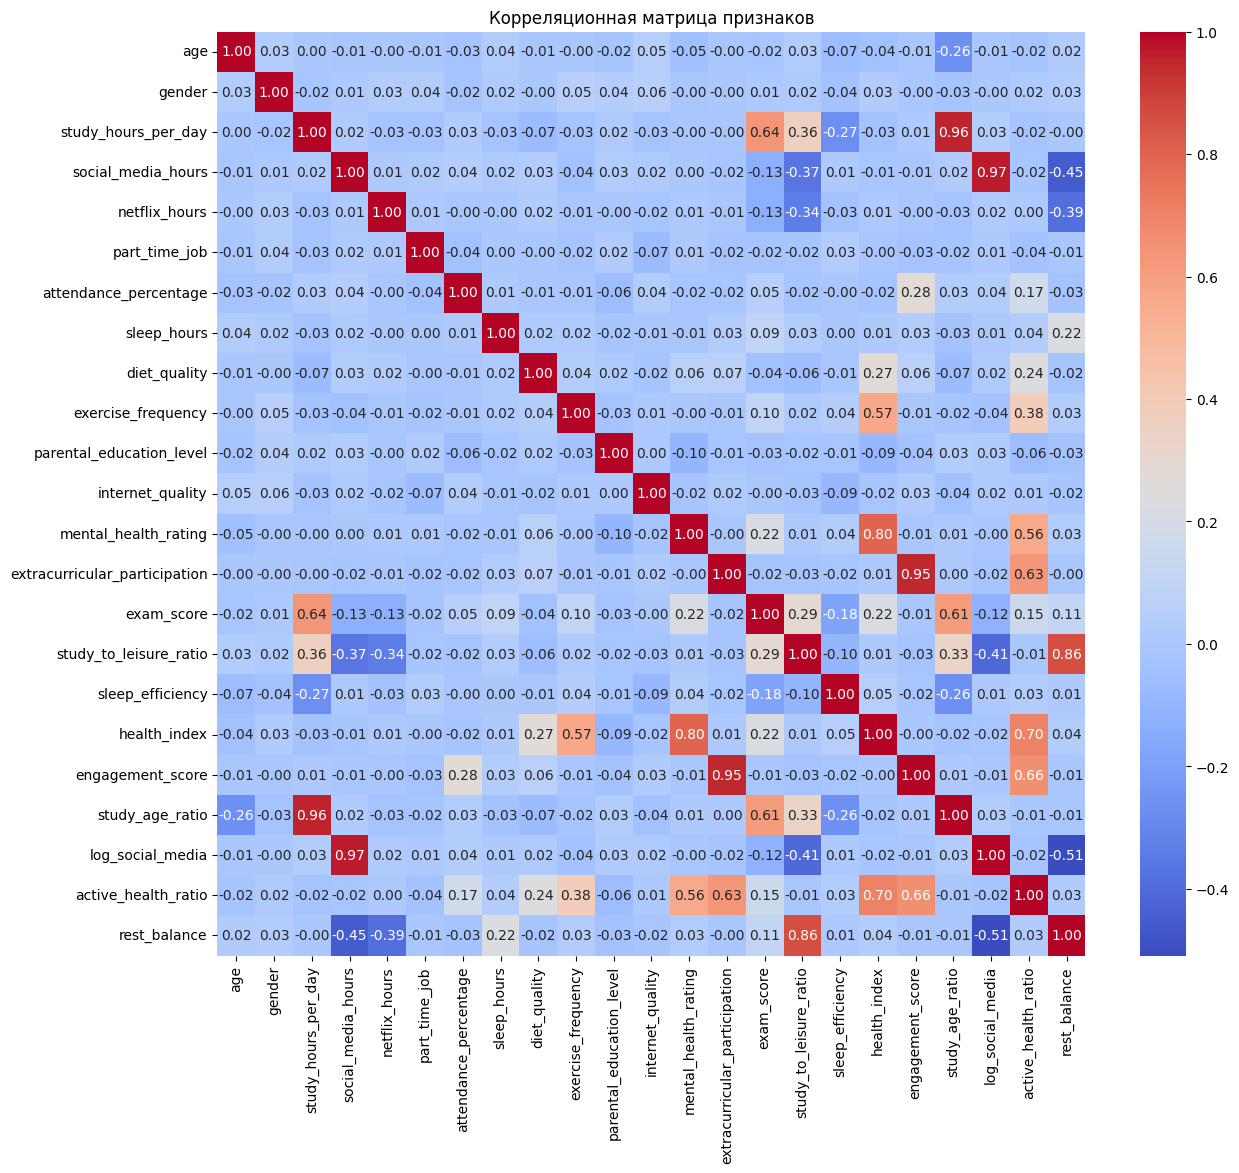

In [584]:
def draw_corr_matrix(df):
    plt.figure(figsize=(14,12))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Корреляционная матрица признаков")
    plt.show()

# example
draw_corr_matrix(df_lin)

Гистограмма распределения

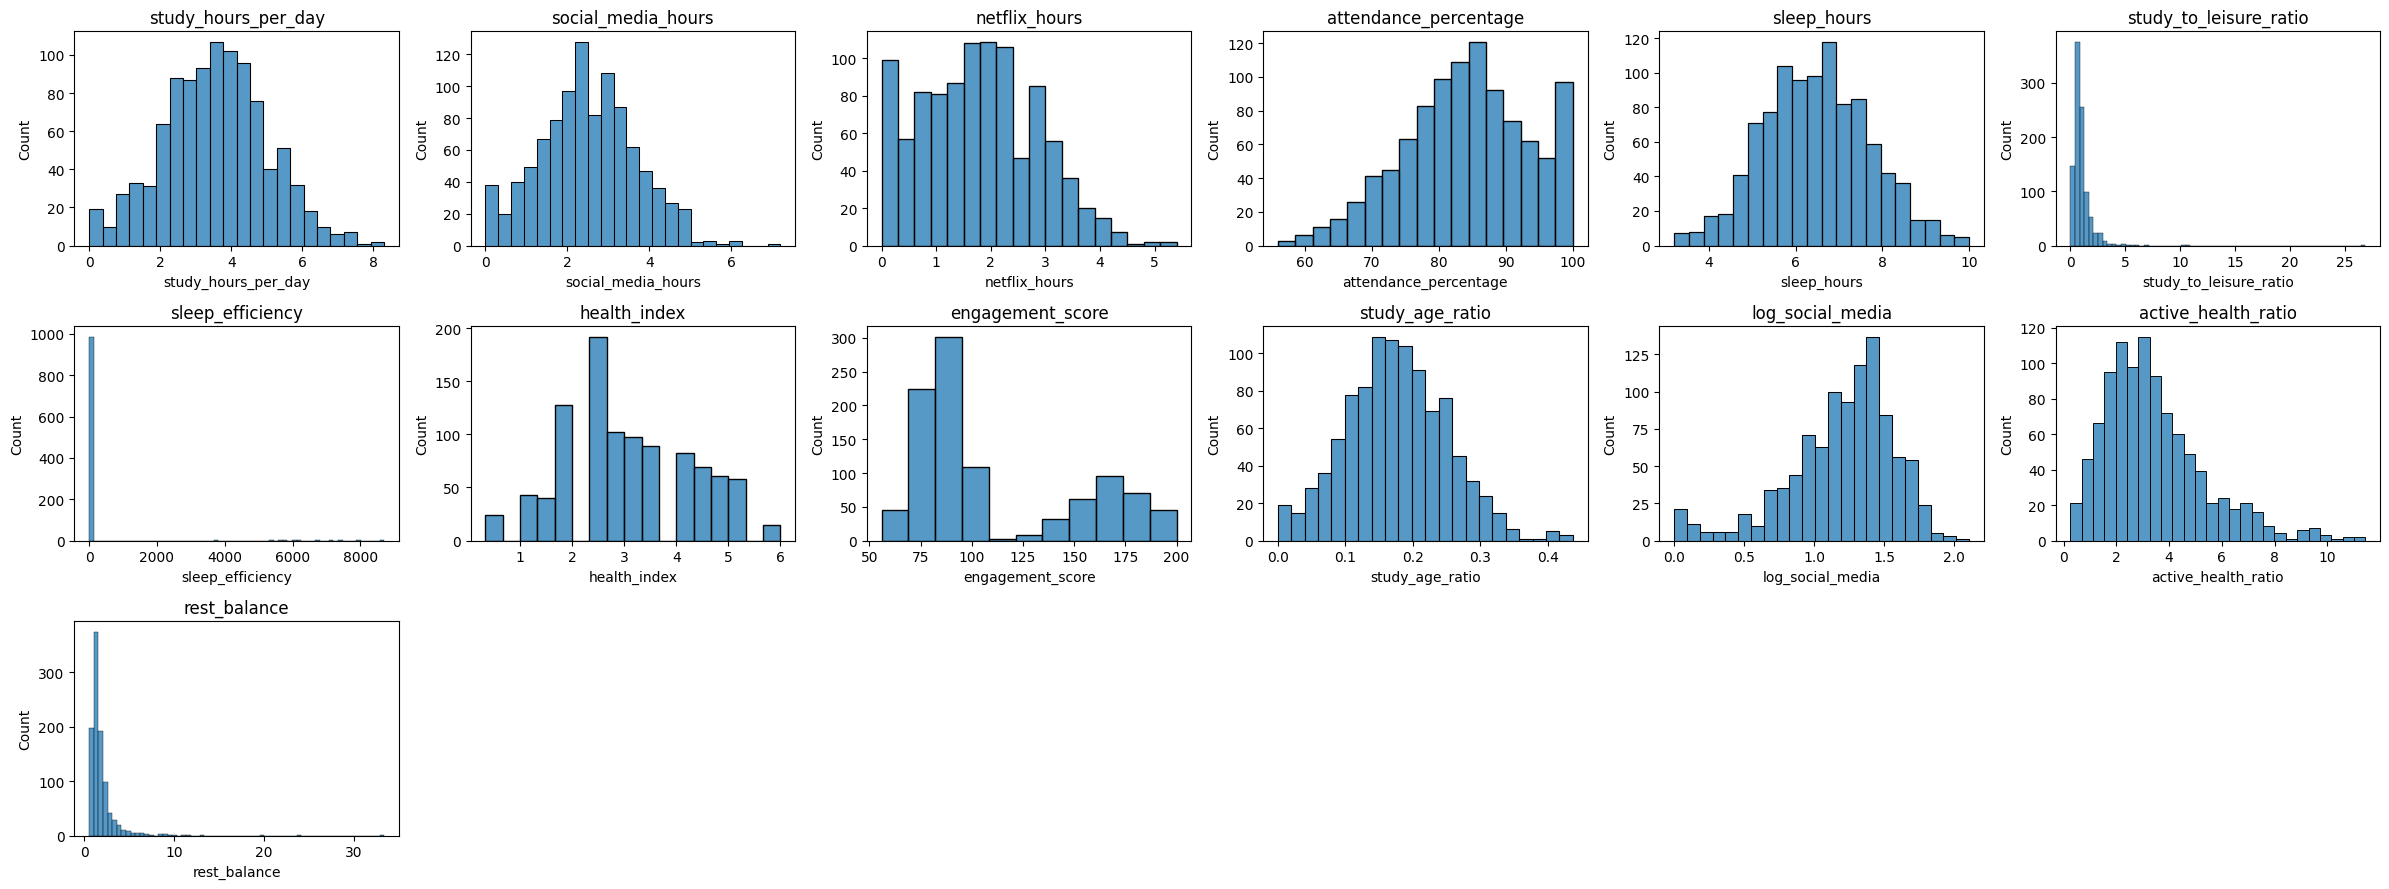

In [585]:
def draw_hist(df: pd.DataFrame, n_cols=6):
    float_cols = df.select_dtypes(include='float').columns[:15]
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()  # делаем одномерным массивом для удобства

    for i, col in enumerate(float_cols):
        sns.histplot(df[col], kde=False, ax=axs[i])
        axs[i].set_title(f'{col}')

    # Если графиков меньше, чем ячеек в сетке, скрываем лишние
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_hist(df_lin)

Соотношение с целевой переменной + коэфициент пирсона

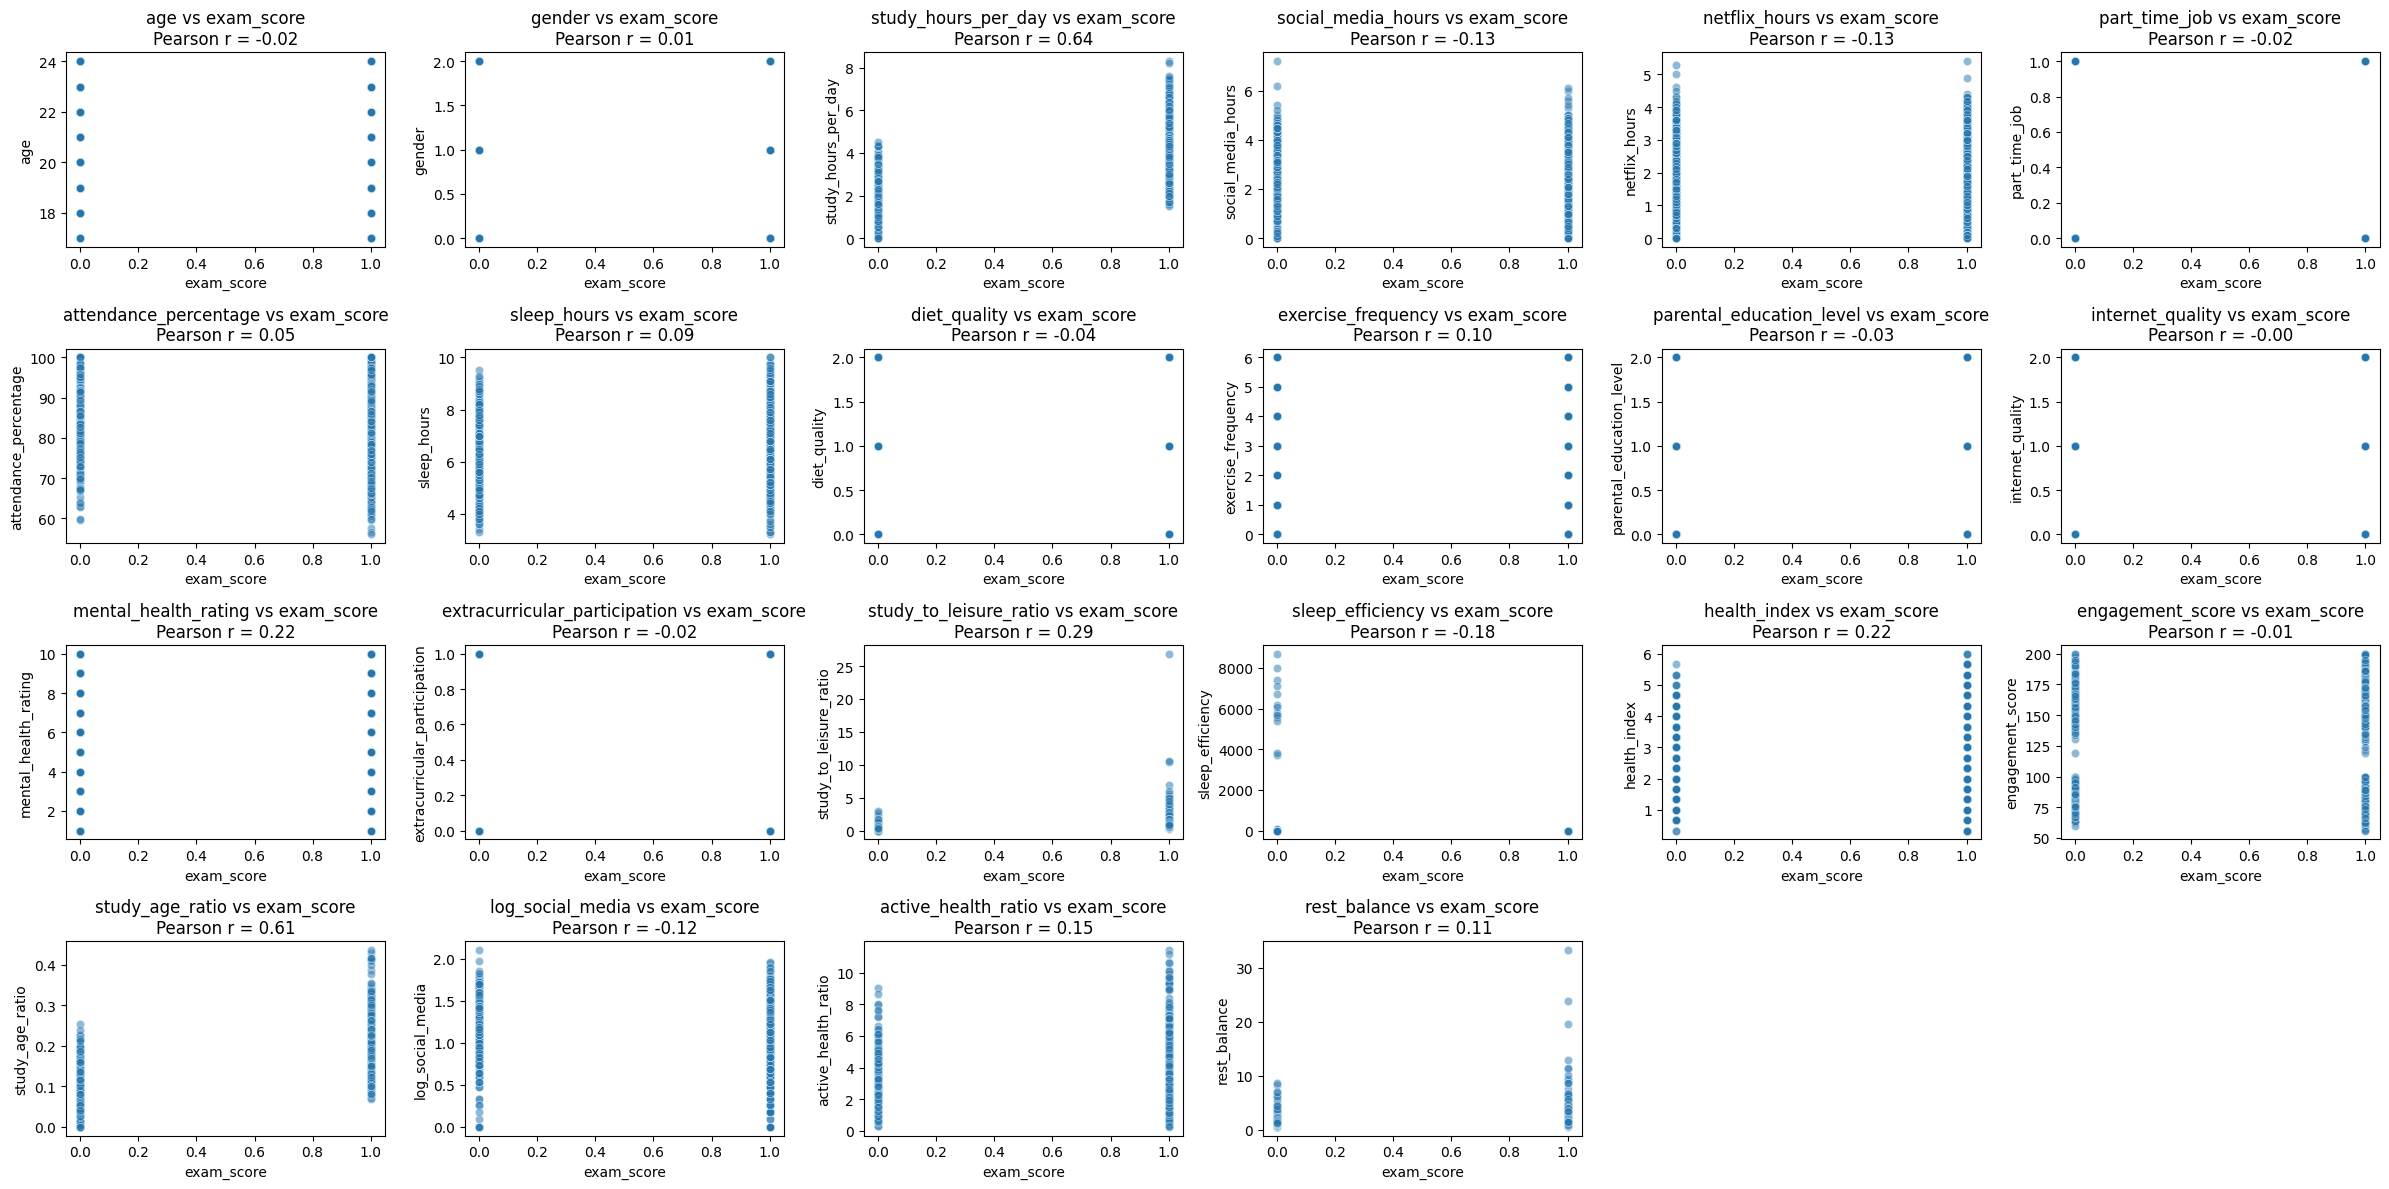

In [586]:
def draw_scatter_vs_target(df: pd.DataFrame, target: str, n_cols=6):
    float_cols = df.select_dtypes(include=['float', 'int']).columns.drop(target)
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()

    for i, col in enumerate(float_cols):
        sns.scatterplot(x=target, y=col, data=df, ax=axs[i], alpha=0.5)

        # коэффициент корреляции Пирсона
        corr = df[col].corr(df[target], method='pearson')
        axs[i].set_title(f'{col} vs {target}\nPearson r = {corr:.2f}')

    # скрываем лишние пустые ячейки
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_scatter_vs_target(df_lin, target="exam_score")

Ящик с усами

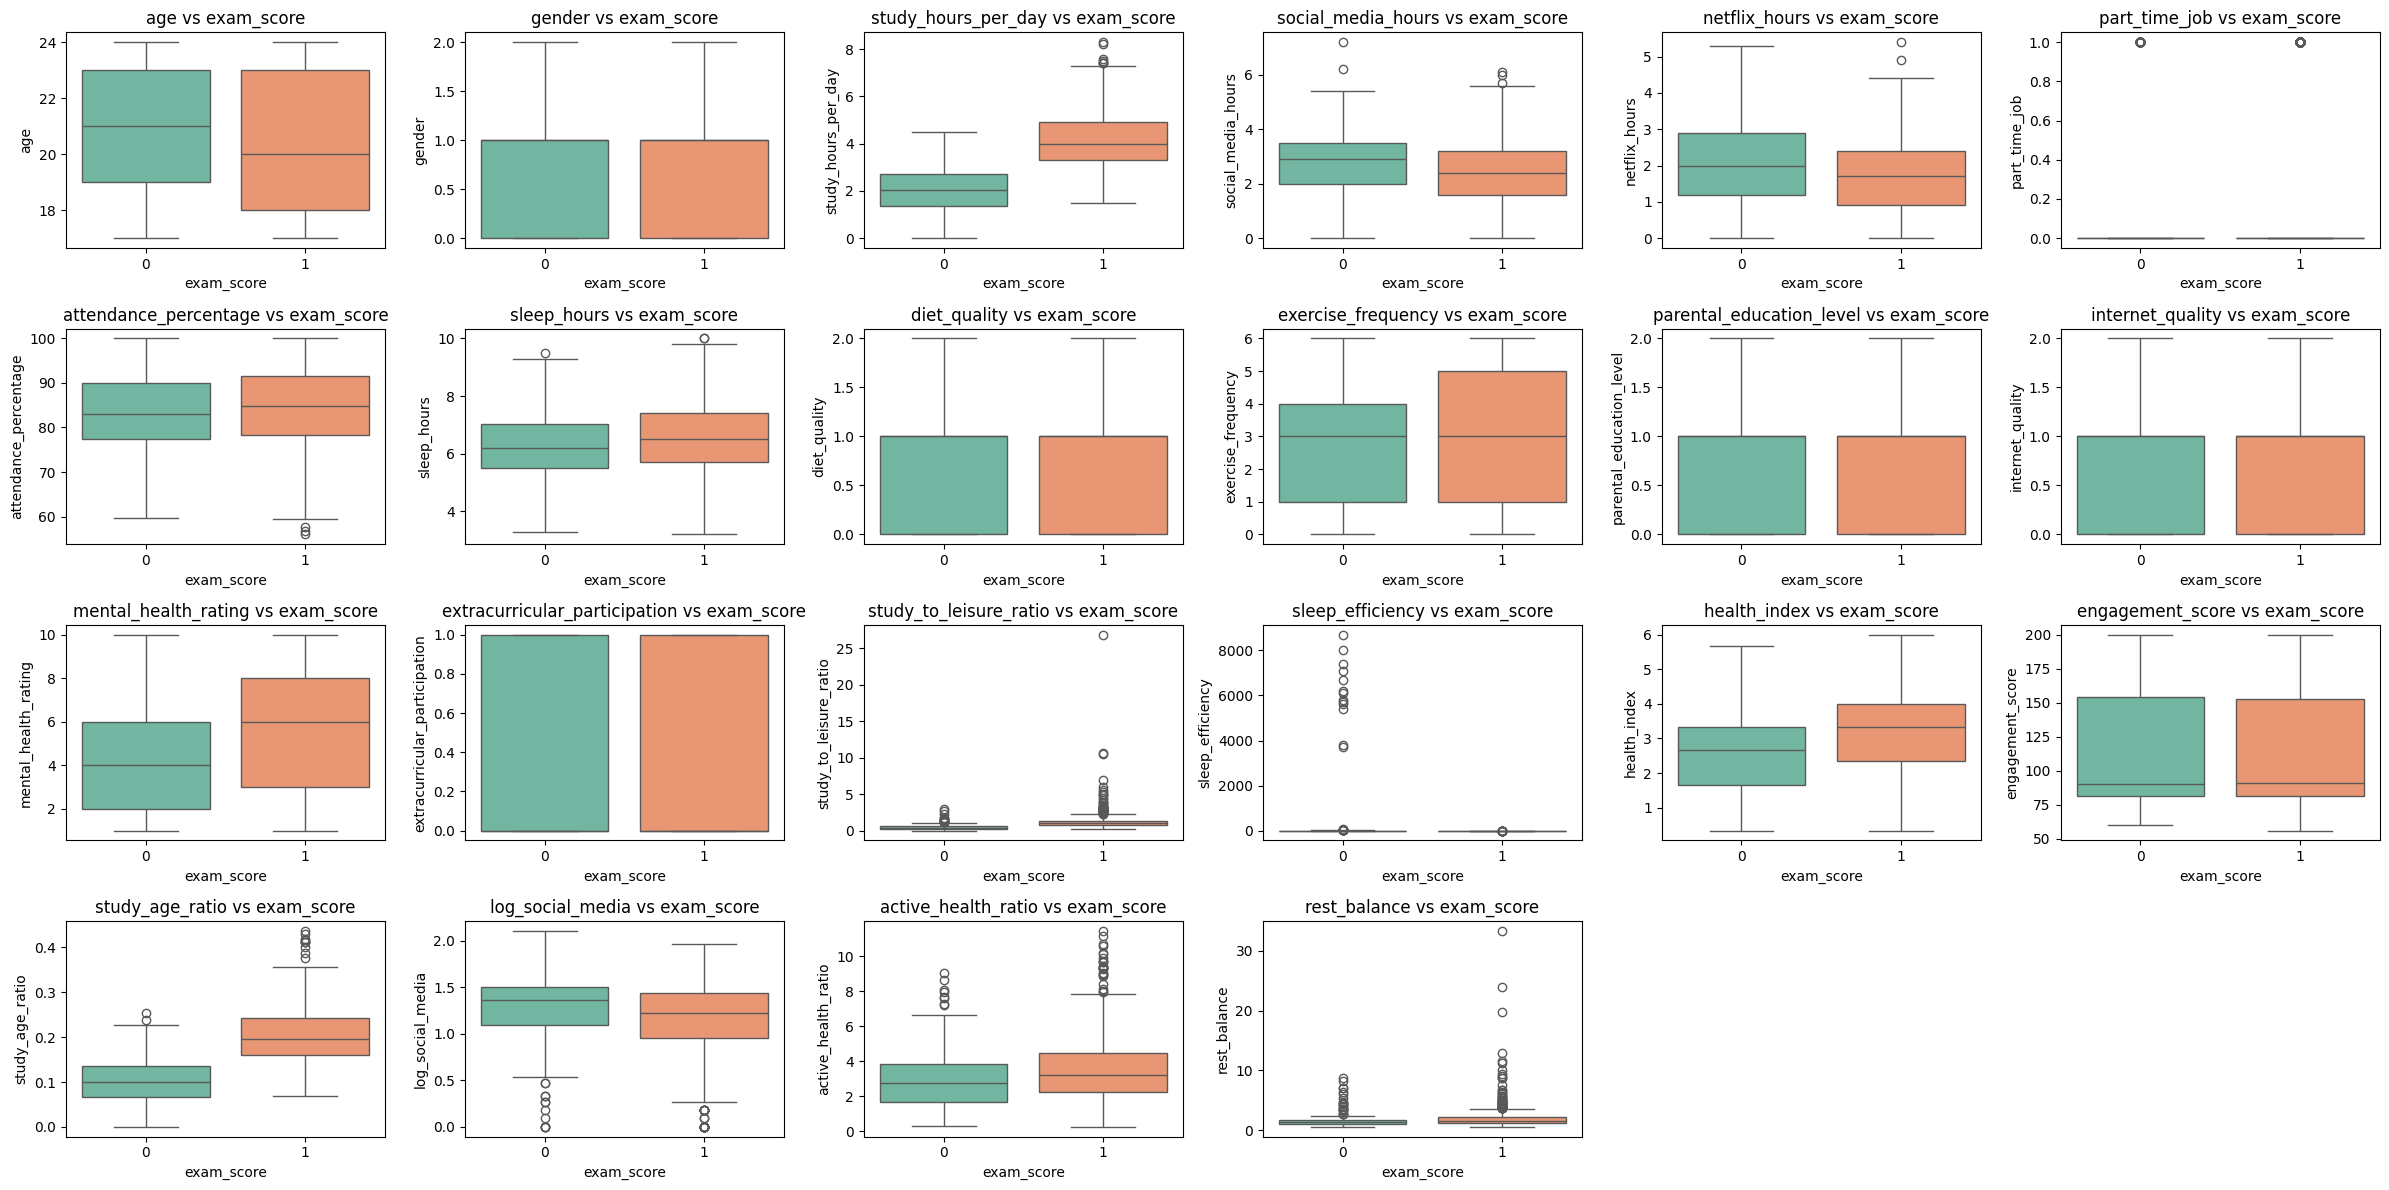

In [587]:
def draw_boxplots(df: pd.DataFrame, target: str, n_cols=6):
    float_cols = df.select_dtypes(include=['float', 'int']).columns.drop(target)
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()

    for i, col in enumerate(float_cols):
        sns.boxplot(
            x=target, y=col, data=df, ax=axs[i],
            hue=target, palette="Set2", legend=False
        )
        axs[i].set_title(f'{col} vs {target}')

    # скрываем лишние пустые ячейки
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_boxplots(df_lin, target="exam_score")

Удаление выбросов

In [588]:
# обработка выбросов
def remove_outliers_iqr(df, columns, low, high):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(low)
        Q3 = df_clean[col].quantile(high)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

Подготовка правых скосов

In [589]:
# обработка скосов
def prepare_skew(df: pd.DataFrame, columns: list[str]):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

#### 2.3.3. Посмотрим на выбросы переменных

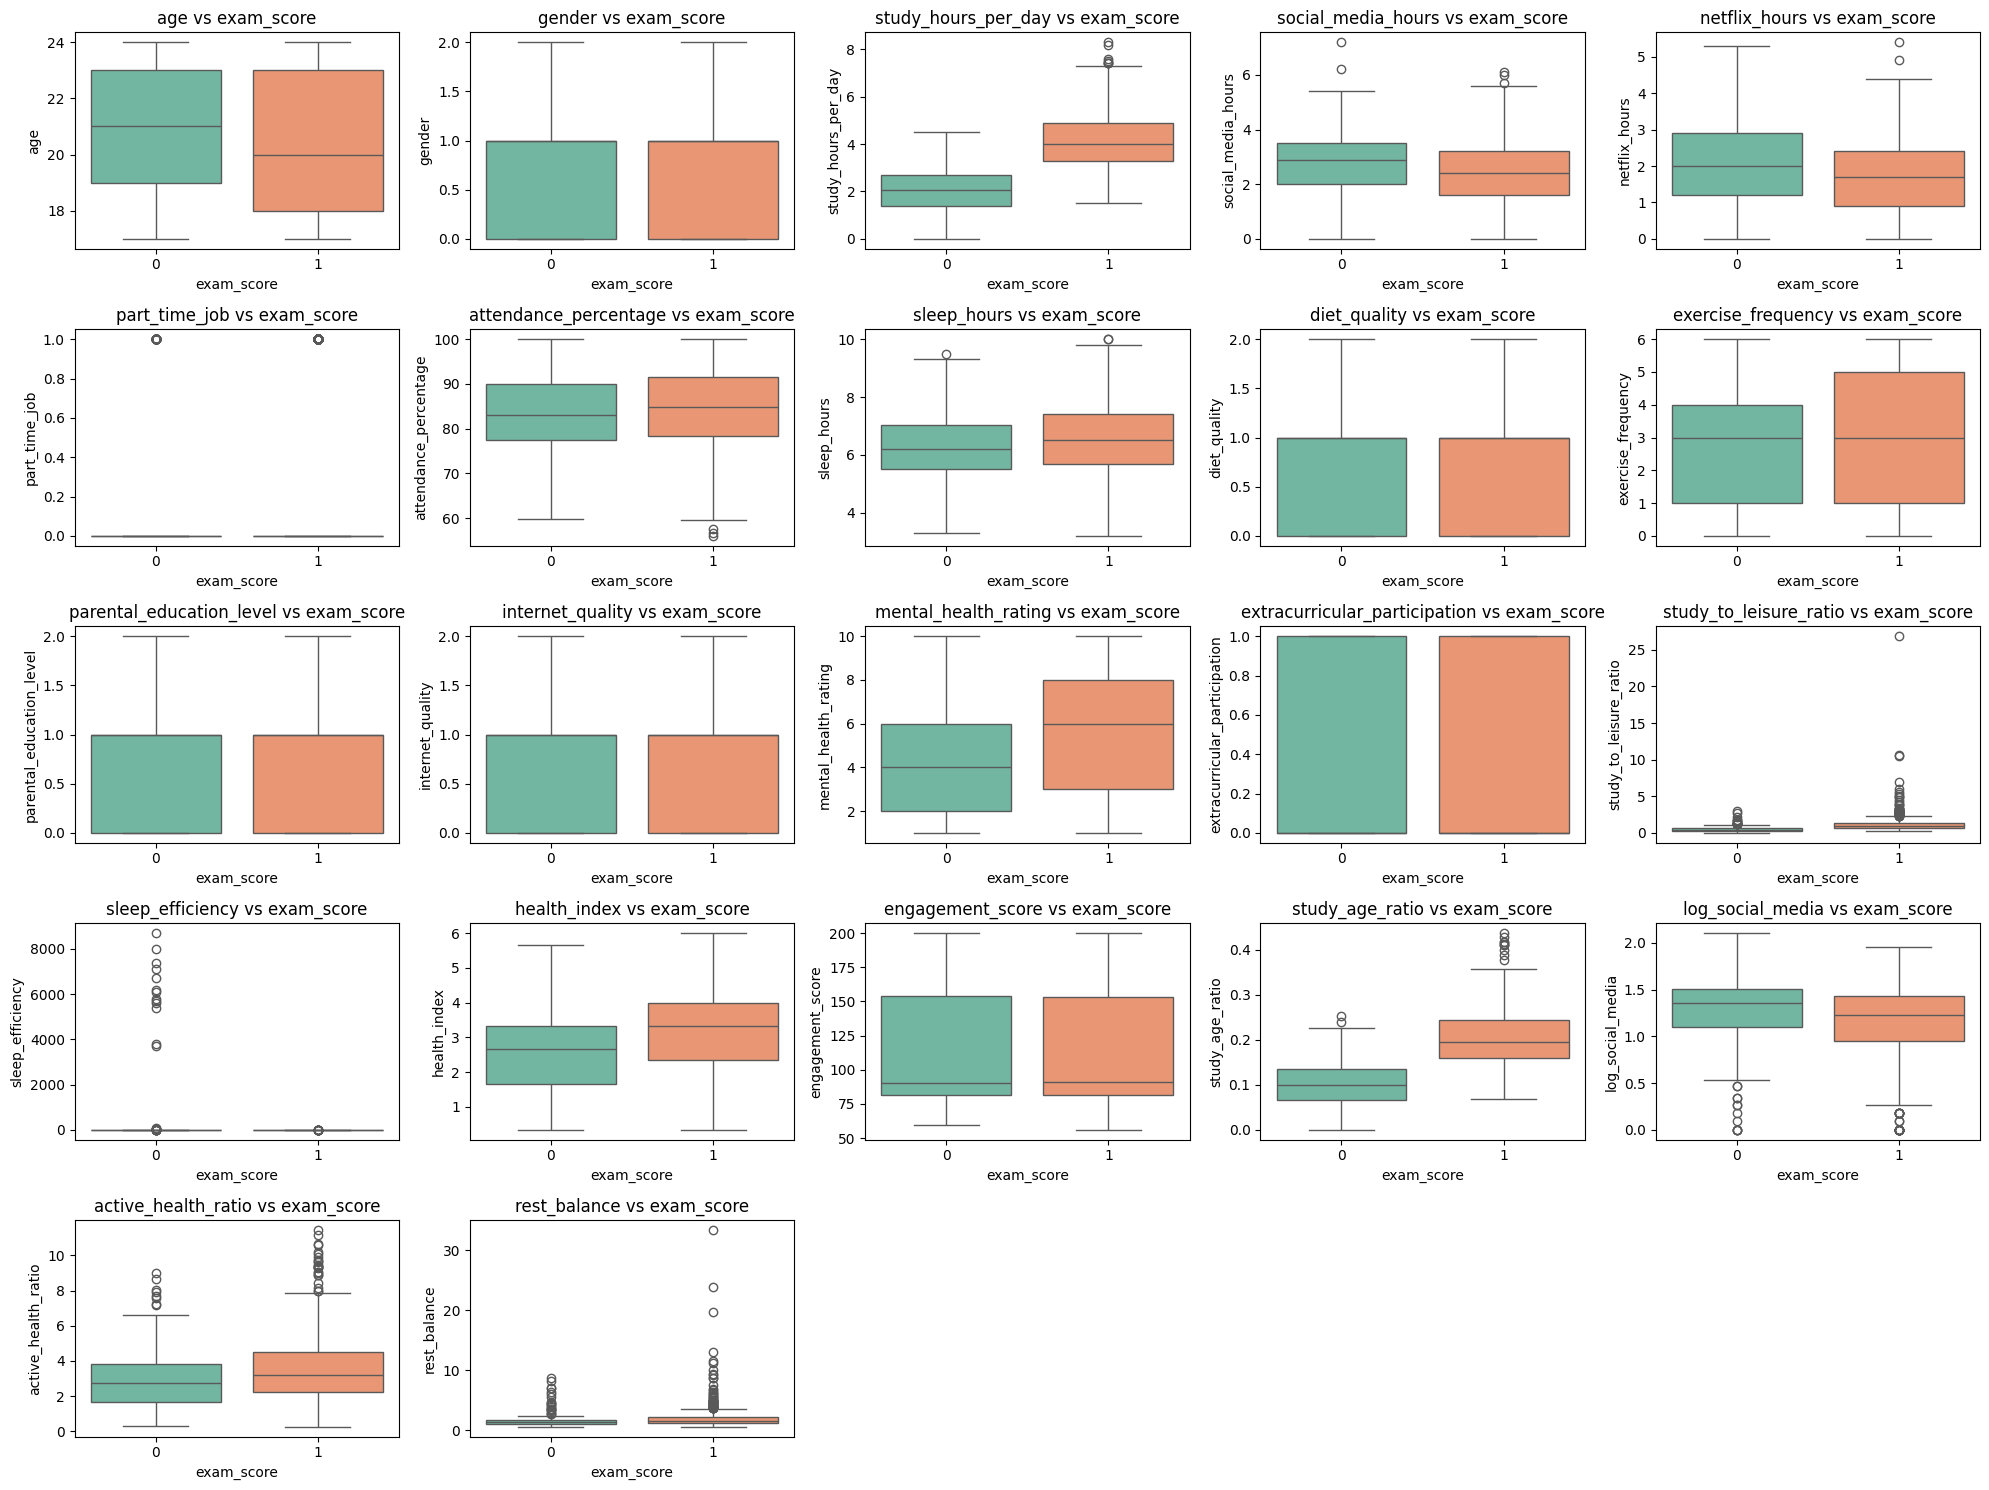

In [590]:
draw_boxplots(df_lin, 'exam_score', n_cols=5)

Удалим выбросы

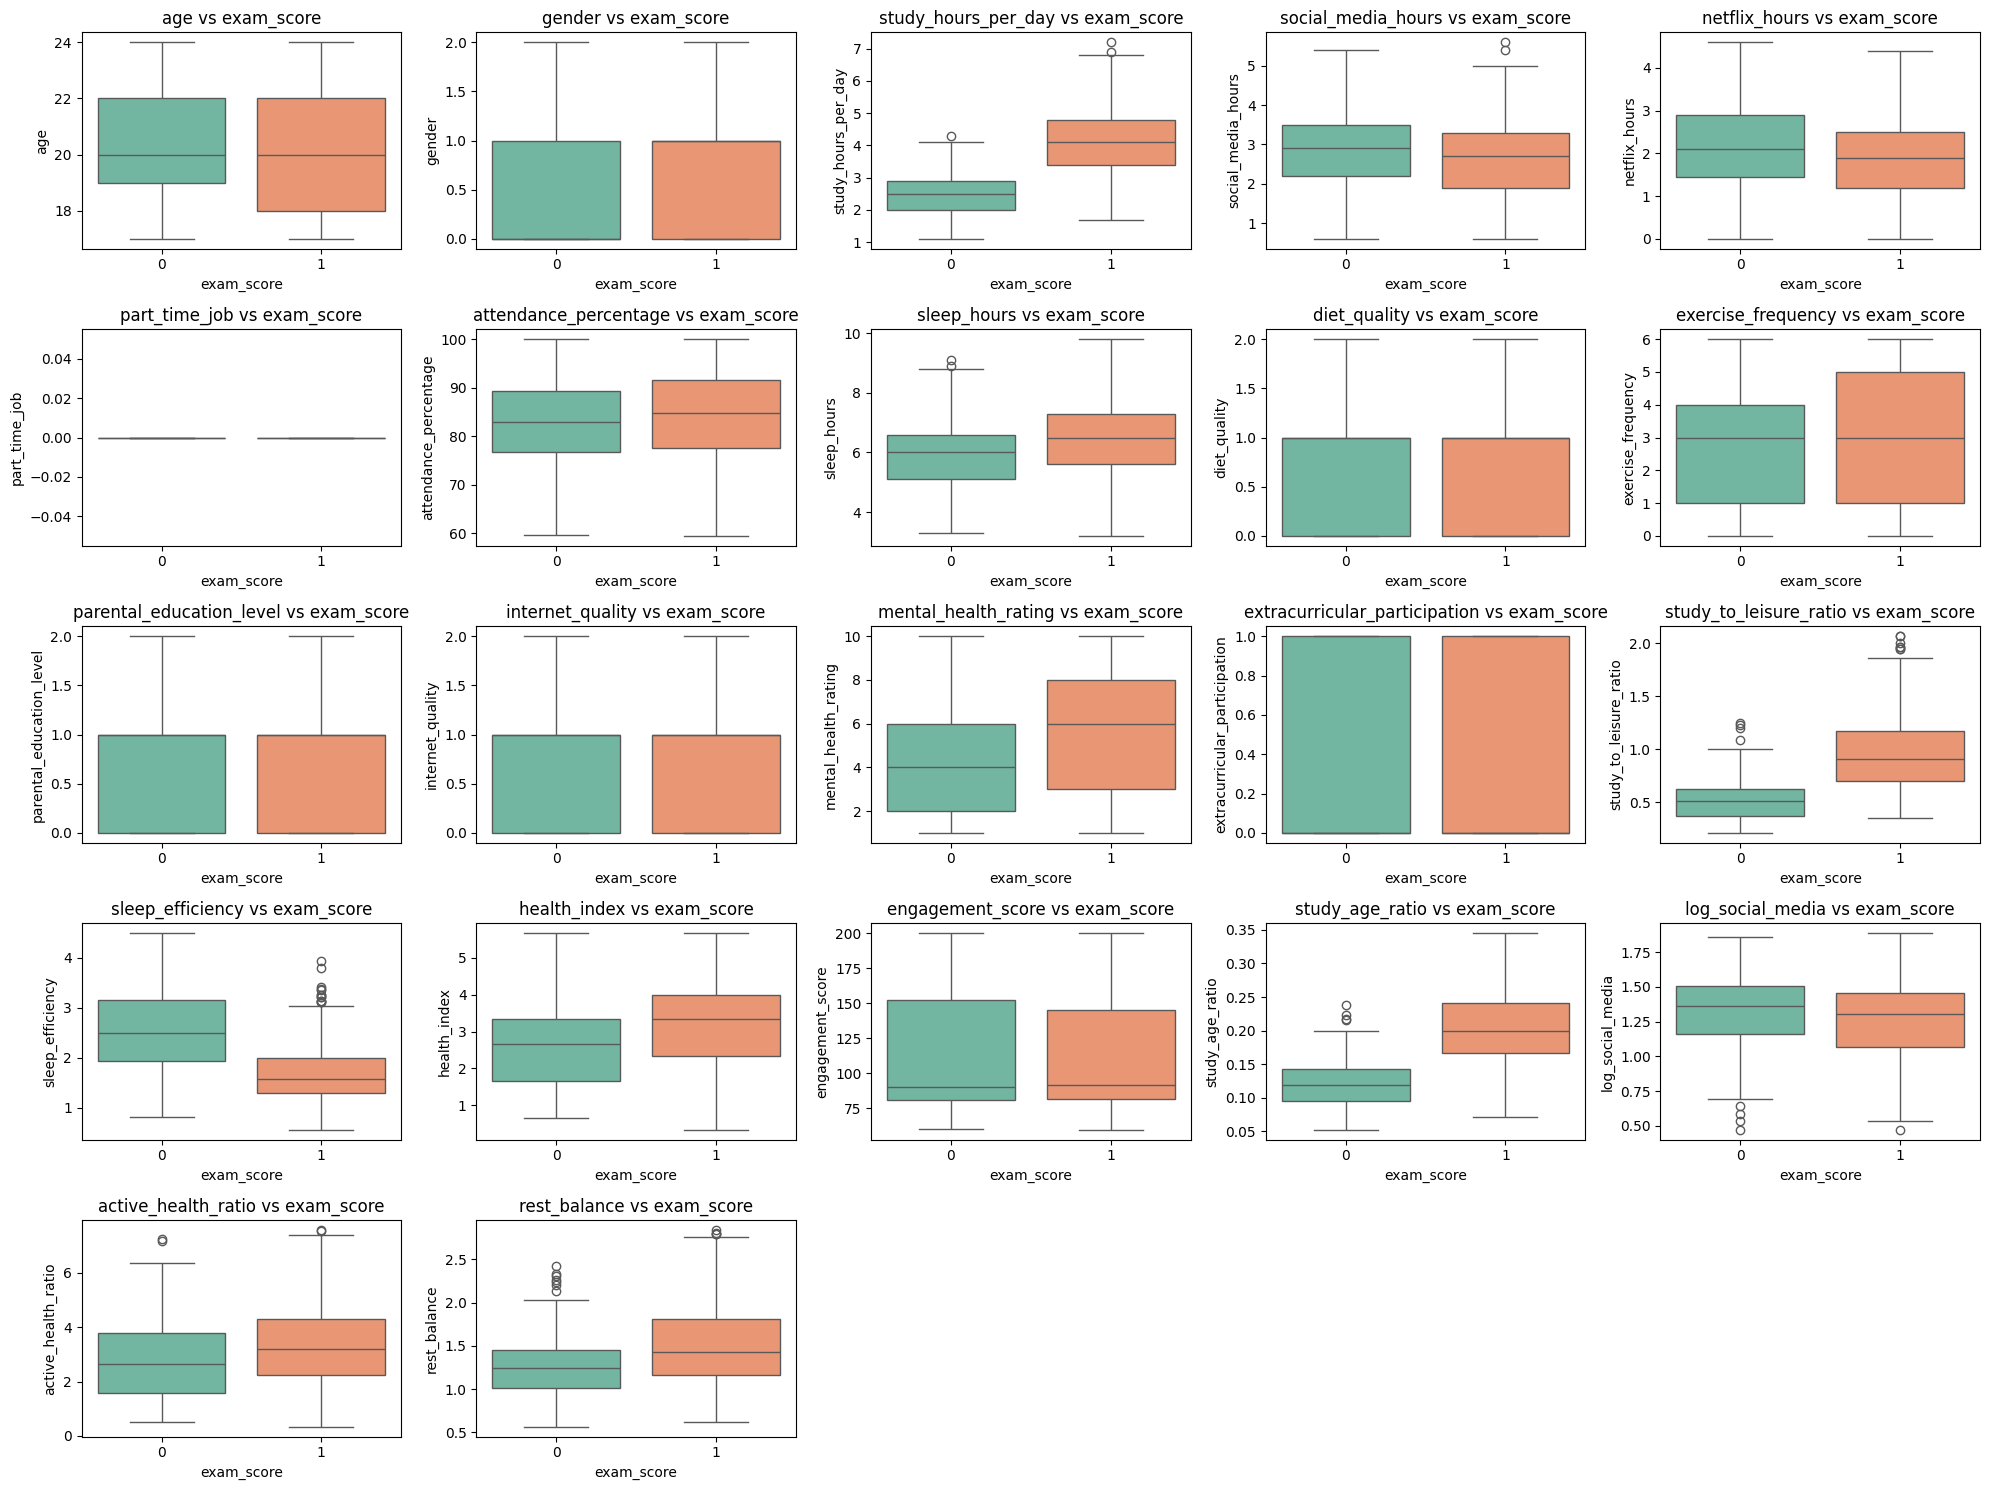

In [591]:
df_lin = remove_outliers_iqr(df_lin, df_lin.select_dtypes(include=['float', 'int']).columns.drop('exam_score'), 0.25, 0.75)
draw_boxplots(df_lin, 'exam_score', n_cols=5)

#### 2.3.4. Посмотрим на скошенные столбцы справа

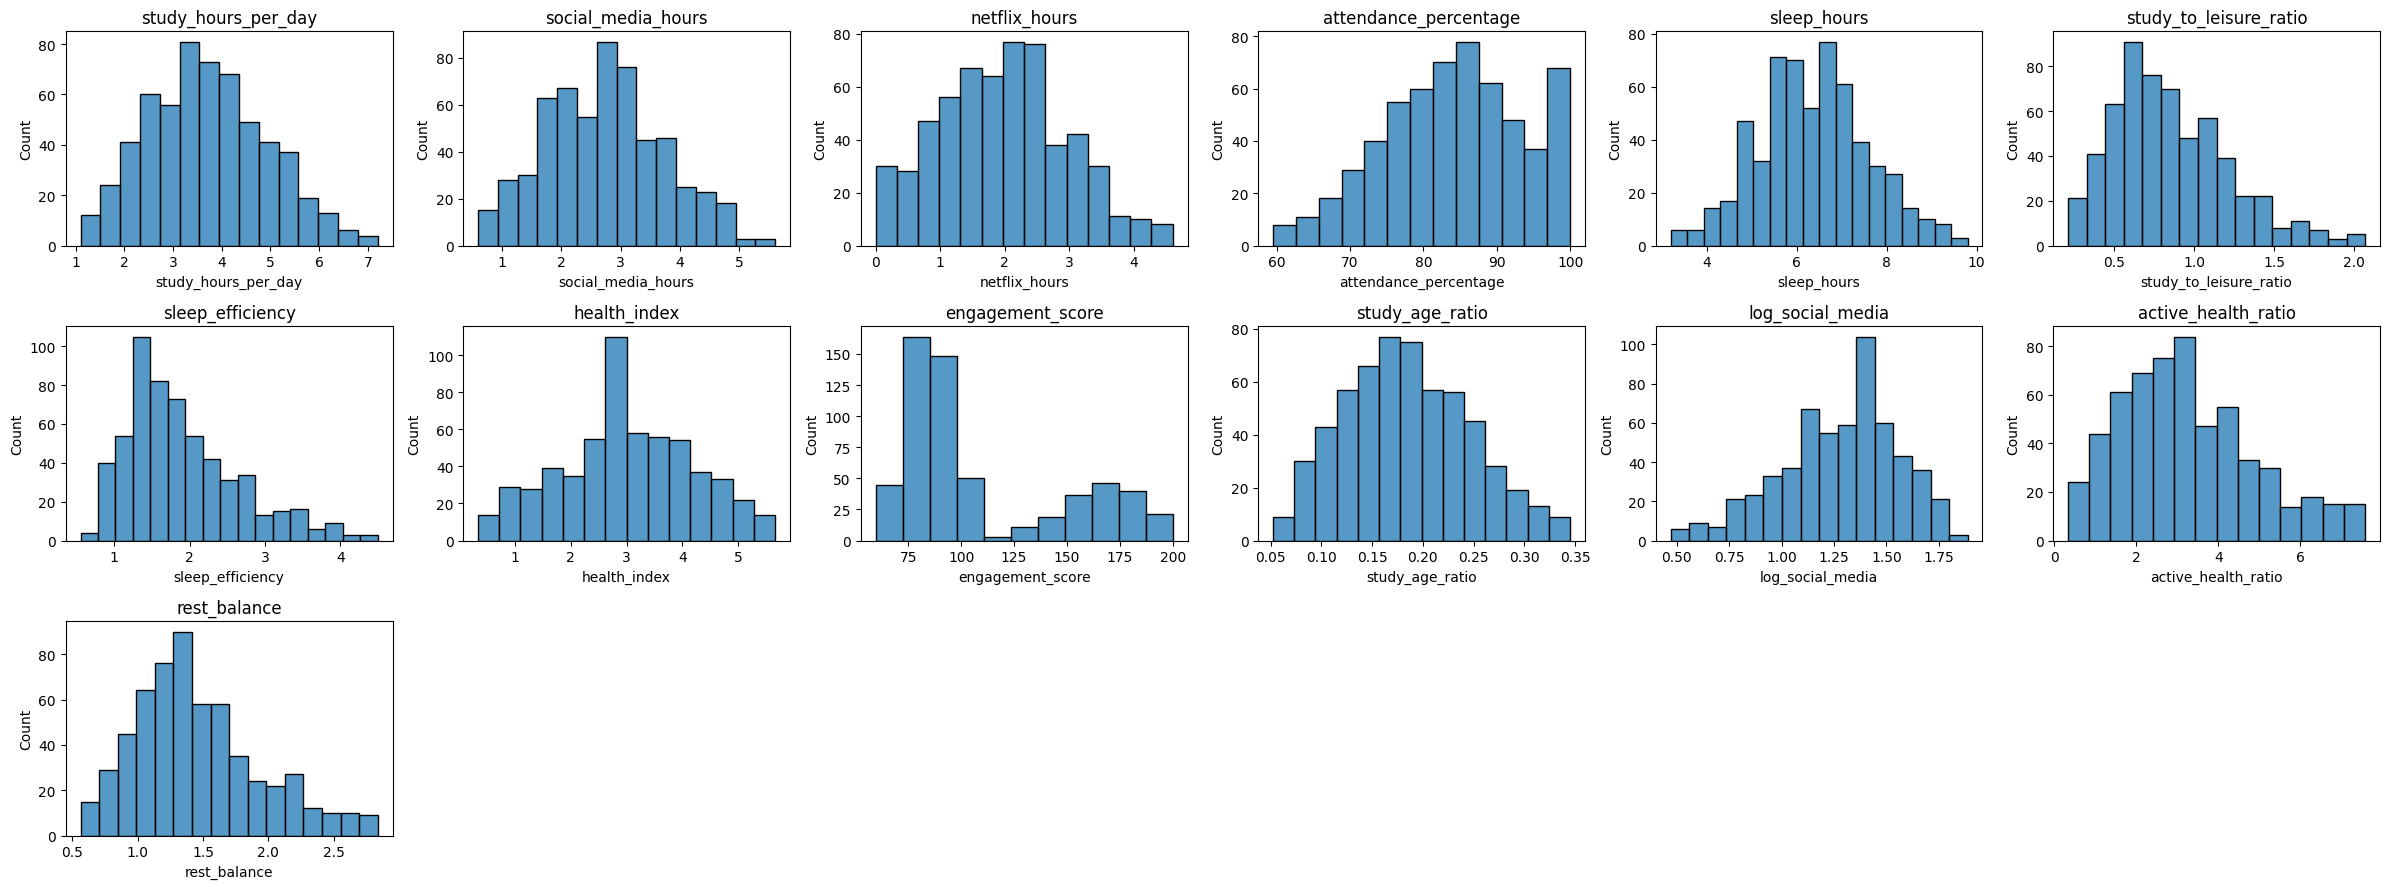

In [592]:
draw_hist(df_lin)

Пытаемся выровнять

In [593]:
skew_values = df_lin.skew()
skew_values_hard = skew_values[abs(skew_values) > 0.5]
skew_values_hard.index

Index(['extracurricular_participation', 'exam_score', 'study_to_leisure_ratio',
       'sleep_efficiency', 'engagement_score', 'active_health_ratio',
       'rest_balance'],
      dtype='object')

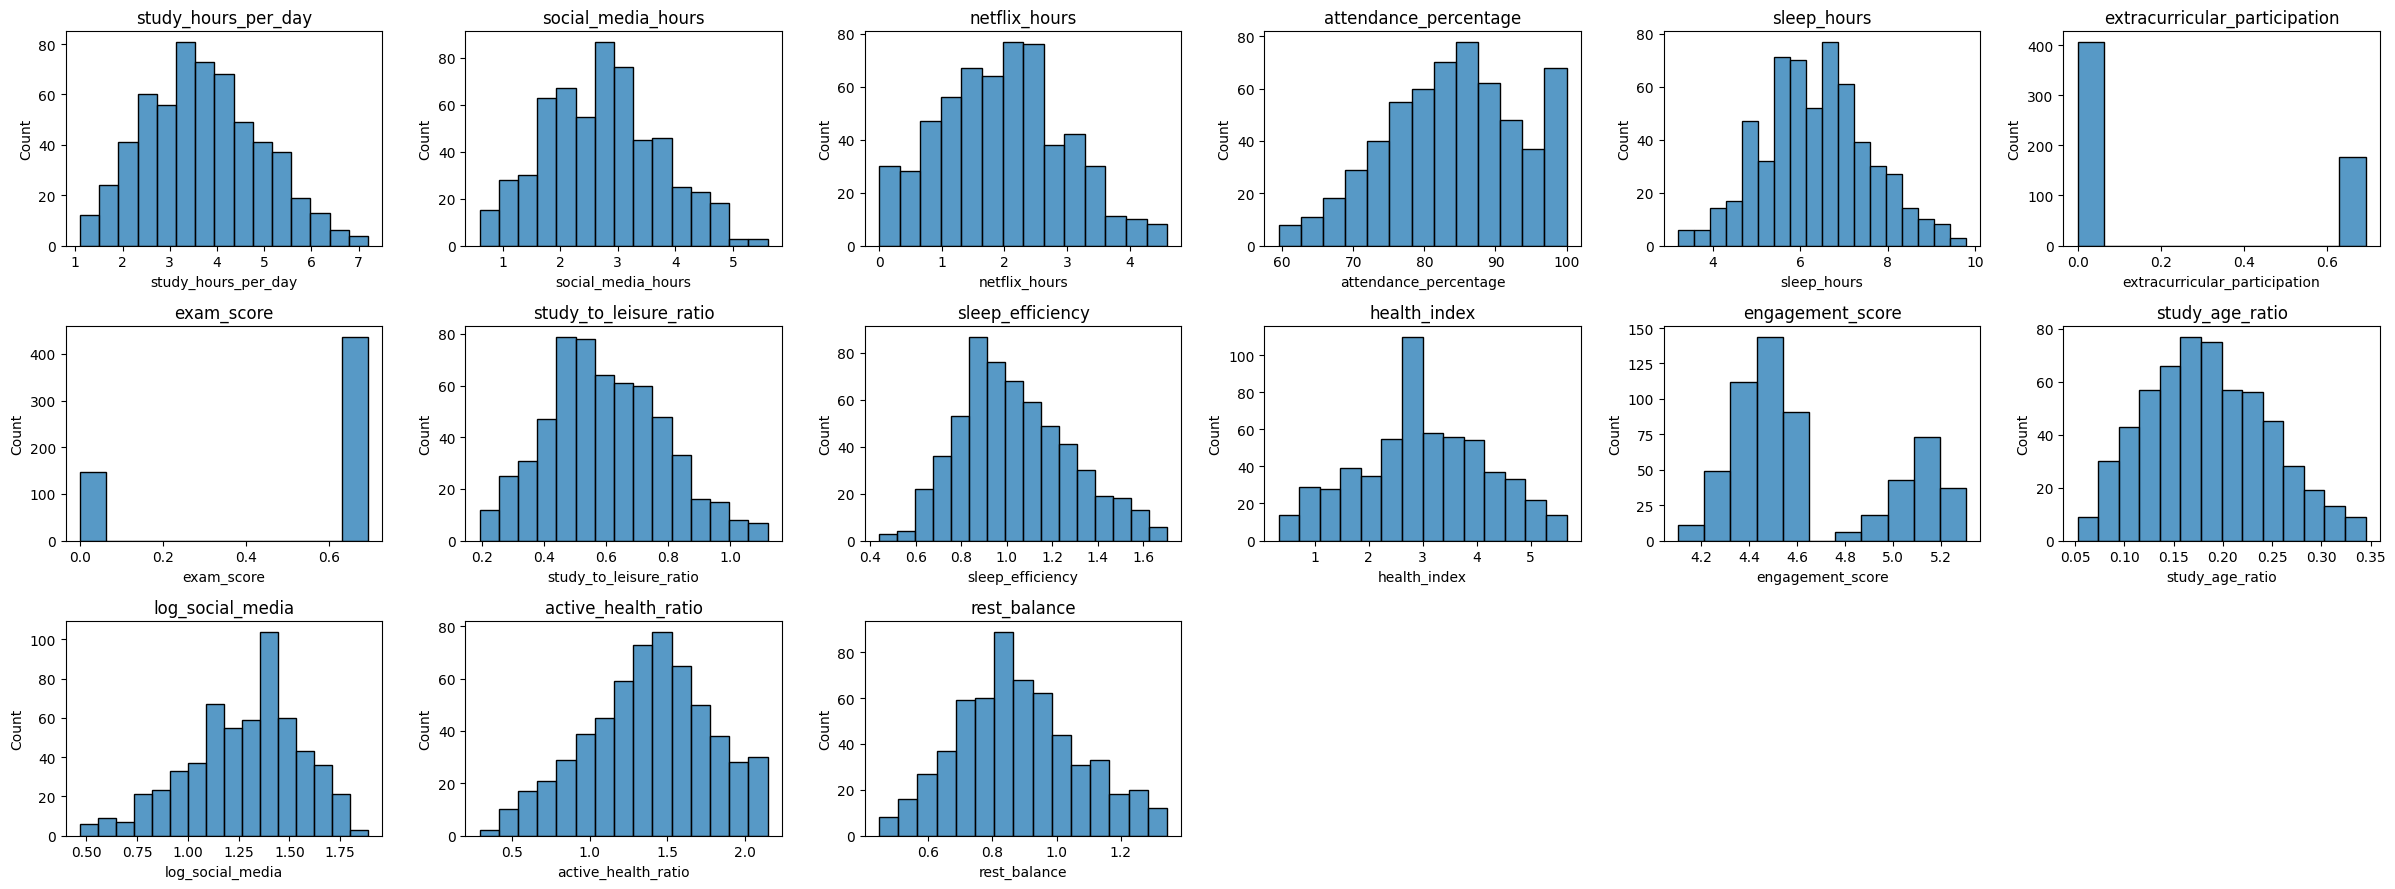

In [594]:
df_lin = prepare_skew(df = df_lin, columns = list(skew_values_hard.index))
draw_hist(df_lin)

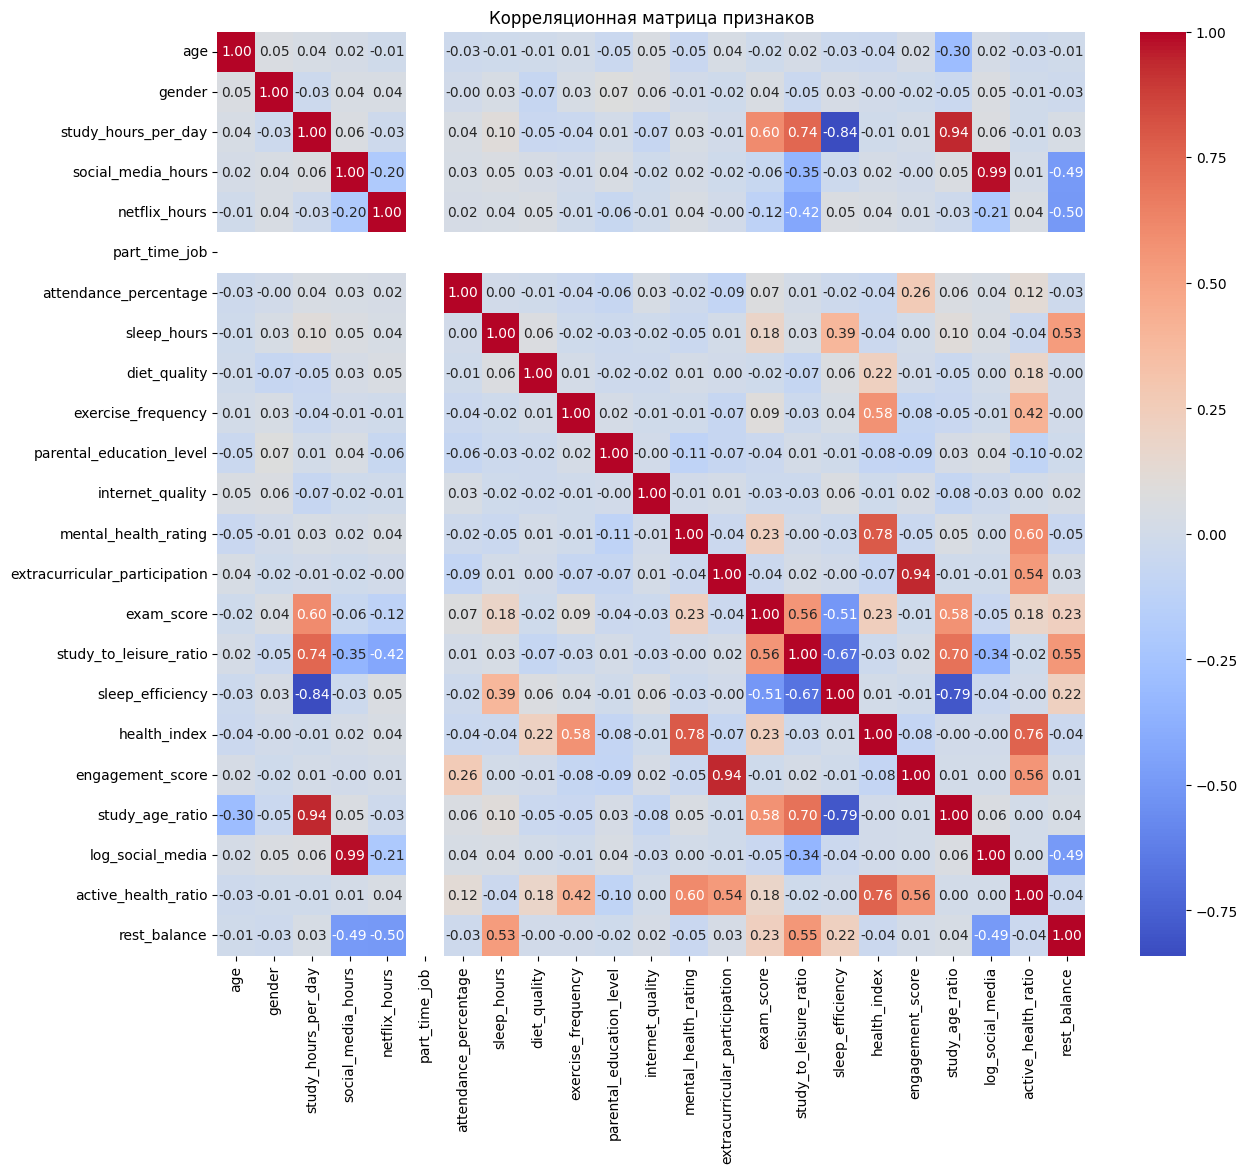

In [595]:
draw_corr_matrix(df_lin)

### 2.4. Разделение вида Фичи - Таргет

Для: `SVM`, `Linear Binary Classification`, `KNN`

In [596]:
y_lin = df_lin['exam_score']
X_lin = df_lin.drop('exam_score', axis=1)
display(X_lin.head(3), y_lin.head(3))

age  gender  study_hours_per_day  social_media_hours  netflix_hours  \
1   20       0                  6.9                 2.8            2.3   
4   19       0                  5.0                 4.4            0.5   
8   23       0                  4.4                 2.2            1.7   

   part_time_job  attendance_percentage  sleep_hours  diet_quality  \
1              0                   97.3          4.6             1   
4              0                   90.9          4.9             0   
8              0                  100.0          7.1             1   

   exercise_frequency  ...  mental_health_rating  \
1                   6  ...                     8   
4                   3  ...                     1   
8                   3  ...                     1   

   extracurricular_participation  study_to_leisure_ratio  sleep_efficiency  \
1                            0.0                0.855553          0.510768   
4                            0.0                0.703196          0.682998   
8                            0.0                0.755143          0.960602   

   health_index  engagement_score  study_age_ratio  log_social_media  \
1      5.000000          4.588024         0.345000          1.335001   
4      1.333333          4.520701         0.263158          1.686399   
8      1.666667          4.615121         0.191304          1.163151   

   active_health_ratio  rest_balance  
1             1.769002      0.642792  
4             0.793897      0.693045  
8             0.980829      1.036753  

[3 rows x 22 columns]

1    0.693147
4    0.693147
8    0.693147
Name: exam_score, dtype: float64

Для: `Desicion Tree`, `Random Forest` и `Gradient's Boosting Methods`

In [597]:
y = df_raw['exam_score']
X = df_raw.drop('exam_score', axis=1)
display(X.head(3), y.head(3))

age  gender  study_hours_per_day  social_media_hours  netflix_hours  \
0   23       0                  0.0                 1.2            1.1   
1   20       0                  6.9                 2.8            2.3   
2   21       1                  1.4                 3.1            1.3   

   part_time_job  attendance_percentage  sleep_hours  diet_quality  \
0              0                   85.0          8.0             0   
1              0                   97.3          4.6             1   
2              0                   94.8          8.0             2   

   exercise_frequency  ...  mental_health_rating  \
0                   6  ...                     8   
1                   6  ...                     8   
2                   1  ...                     1   

   extracurricular_participation  study_to_leisure_ratio  sleep_efficiency  \
0                              1                0.000000       8000.000000   
1                              0                1.352676          0.666570   
2                              0                0.318110          5.710207   

   health_index  engagement_score  study_age_ratio  log_social_media  \
0      4.666667             170.0         0.000000          0.788457   
1      5.000000              97.3         0.345000          1.335001   
2      1.333333              94.8         0.066667          1.410987   

   active_health_ratio  rest_balance  
0             7.933333      3.476749  
1             4.865000      0.901784  
2             1.264000      1.817769  

[3 rows x 22 columns]

0    0
1    1
2    0
Name: exam_score, dtype: int64

## 3. Создание моделей

### 3.0. Создание `SVM`, `Linear Binary Classification`, `KNN`

#### Support Vector Machine

[Почитать 1](https://scikit-learn.org/stable/modules/svm.html)

[Почитать 2](https://t.me/devwhoami/179)

Метод опорных векторов (Support Vector Machine, **SVM**) — это мощный и популярный алгоритм **линейной** (и нелинейной) **классификации**.

Основная идея:

1.  **Разделяющая гиперплоскость**: SVM находит оптимальную гиперплоскость (линию в 2D, плоскость в 3D), которая **наилучшим образом разделяет** классы в вашем наборе данных.
2.  **Максимизация зазора (Margin)**: "Наилучшим образом" означает, что гиперплоскость должна находиться на **максимальном расстоянии** от ближайших точек каждого класса. Это расстояние называется **зазором (margin)**.
3.  **Опорные векторы (Support Vectors)**: Только те точки данных, которые находятся **ближе всего** к гиперплоскости и определяют ширину зазора, называются **опорными векторами**. Эти точки имеют решающее значение; если их удалить, положение гиперплоскости может измениться.
4.  **Ядерный трюк (Kernel Trick)**: Для **нелинейно** разделимых данных SVM использует так называемый **ядерный трюк**. Он неявно проецирует данные в пространство более высокой размерности, где классы становятся линейно разделимыми, и находит там оптимальную гиперплоскость.

**Кратко**: SVM строит **широчайший возможный "коридор"** между классами, опираясь только на самые сложные (граничные) точки — опорные векторы.

In [598]:
from sklearn.svm import SVC

model_svm = SVC(
    C=1.0,           # Параметр регуляризации. Чем меньше C, тем шире зазор, тем больше ошибок допускается (сильнее регуляризация).
                     # Варианты: 0.1, 1, 10, 100.

    kernel='rbf',    # Тип ядра. Определяет, как данные будут проецироваться в пространство более высокой размерности.
                     # Варианты: 'linear' (линейный классификатор), 'poly' (полиномиальный),
                     # 'rbf' (Радиальная базисная функция - наиболее часто используется для нелинейных задач), 'sigmoid'.

    gamma='scale',   # Коэффициент ядра (для 'rbf', 'poly', 'sigmoid'). Определяет "влияние" одного обучающего примера.
                     # Варианты: 'scale' (1 / (n_features * X.var())) или 'auto' (1 / n_features) - рекомендуются по умолчанию.
                     # Или: небольшие значения (0.01, 0.1) для широкого влияния; большие значения (1, 10) для узкого влияния.

    degree=3,        # Степень полинома (для 'poly' ядра). Игнорируется для других ядер.
                     # Варианты: 2, 3, 4.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    probability=False # Включает оценку вероятности классов (медленнее, но иногда нужно).
                      # Варианты: True (если нужны предсказанные вероятности), False (по умолчанию, если нужна только классификация).
)


#### Logistic Regression

**Логистическая регрессия — краткое пояснение:**

Логистическая регрессия — это метод машинного обучения, используемый для решения задач **классификации**, то есть когда нужно предсказать, к какому классу принадлежит объект (например, «да/нет», «0/1»).

В отличие от линейной регрессии, логистическая регрессия предсказывает **вероятность принадлежности** объекта к определённому классу. Для этого используется **логистическая (сигмоидная) функция**, которая преобразует линейную комбинацию признаков в значение от 0 до 1.

Основные шаги:

1. Строится линейная модель:
    $$z = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n$$
2. К результату применяется сигмоида:
   $$p = \frac{1}{1 + e^{-z}}$$
3. Если ($p > 0.5$), то объект относят к классу 1, иначе — к классу 0.

Модель обучается с помощью **максимизации правдоподобия** (обычно через метод градиентного спуска).


In [599]:
from sklearn.linear_model import LogisticRegression

model_logreg = LogisticRegression(
    penalty='l2',        # Тип регуляризации, добавляемой для предотвращения переобучения.
                         # 'l2' — стандартная (ридж-регуляризация), 'l1' — лассо-регуляризация (зануляет некоторые коэффициенты).
                         # Варианты: 'l1', 'l2', 'elasticnet', 'none'.

    C=1.0,               # Обратный коэффициент силы регуляризации.
                         # Чем меньше C — тем сильнее регуляризация (жестче штраф за большие коэффициенты).
                         # Варианты: 0.01, 0.1, 1, 10, 100.

    solver='lbfgs',      # Алгоритм оптимизации для нахождения весов модели.
                         # 'lbfgs' — универсальный и быстрый (подходит для малых и средних наборов данных).
                         # Другие варианты: 'liblinear' (поддерживает L1), 'saga' (работает с большими данными и L1/L2), 'newton-cg'.

    max_iter=100,        # Максимальное число итераций для сходимости алгоритма.
                         # Если обучение не сходится — увеличить, например до 500.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов (фиксирует начальные веса).

    fit_intercept=True,  # Добавляет свободный коэффициент (смещение) в модель.
                         # Обычно True, чтобы учитывать среднее значение признаков.

    n_jobs=None          # Количество потоков для параллельных вычислений.
                         # None — одно ядро, -1 — использовать все доступные ядра процессора.
)


#### K-Nearest Neighbors (KNN)

**Метод k-ближайших соседей — краткое пояснение:**

KNN (*k-nearest neighbors*) — это простой и интуитивный метод машинного обучения, применяемый для задач **классификации** и **регрессии**.
Он не строит явной модели — вместо этого принимает решение, основываясь на **схожести объектов** в пространстве признаков.

Идея метода:
Для нового объекта алгоритм ищет **k ближайших соседей** из обучающей выборки (по выбранной метрике расстояния) и определяет класс по **голосованию** этих соседей.

Основные шаги:

1. Выбирается число соседей $k$ — например, 3 или 5.
2. Для нового объекта вычисляются расстояния до всех объектов обучающей выборки.
3. Определяются $k$ ближайших точек.
4. Класс объекта определяется по большинству классов среди соседей.

Метод KNN **не имеет этапа обучения**, так как просто запоминает обучающие данные.
Основной параметр, влияющий на качество модели — это число соседей $k$:

* Малое $k$ делает модель чувствительной к шуму.
* Большое $k$ сглаживает границы между классами.


In [600]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(
    n_neighbors=5,      # Количество ближайших соседей (k).
                        # Малое значение делает модель чувствительной к шуму, большое — сглаживает предсказания.
                        # Варианты: 3, 5, 7, 9 и т.д.

    weights='uniform',  # Веса соседей при голосовании.
                        # 'uniform' — все соседи равны,
                        # 'distance' — соседи ближе к объекту имеют больший вес.

    metric='minkowski', # Метрика расстояния.
                        # По умолчанию 'minkowski' с p=2 соответствует евклидову расстоянию.
                        # Варианты: 'euclidean', 'manhattan', 'chebyshev', 'minkowski'.

    p=2,                # Степень метрики Минковского (p=1 — манхэттен, p=2 — евклид).
                        # Меняется только если выбран 'minkowski'.

    algorithm='auto',   # Алгоритм поиска ближайших соседей.
                        # 'auto' выбирает оптимальный метод (ball_tree, kd_tree, brute) в зависимости от данных.

    n_jobs=None         # Количество потоков для вычислений.
                        # None — одно ядро, -1 — использовать все доступные ядра процессора.
)

### 3.1. Создание `Desicion Tree`, `Random Forest`

#### Decision Tree Classifier (Дерево решений)

**Дерево решений — краткое пояснение:**

Дерево решений — это алгоритм **классификации и регрессии**, который принимает решения, разбивая данные по признакам в виде **дерева с узлами и ветвями**.
Каждый узел дерева соответствует условию на значение признака (например, «возраст > 30?»), а листья — это **предсказанные классы**.

Идея метода:
Алгоритм рекурсивно делит выборку на подмножества так, чтобы в каждом из них объекты как можно больше принадлежали одному классу.
Критерием “хорошего разбиения” служат меры **чистоты узла** — например, *Gini* или *энтропия*.

Основные шаги:

1. Выбирается признак и порог, которые лучше всего разделяют данные по целевой переменной.
2. Создаются новые ветви для каждого значения или диапазона признака.
3. Процесс повторяется до тех пор, пока не достигнуты условия остановки (например, максимальная глубина).
4. Листовые узлы содержат итоговые классы.

Преимущества:

* Простая интерпретация (можно визуализировать дерево).
* Не требует масштабирования данных.

Недостатки:

* Склонно к **переобучению**, особенно при большой глубине дерева.
* Может быть нестабильным (небольшие изменения данных → другое дерево).

In [601]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(
    criterion='gini',       # Критерий качества разбиения.
                            # 'gini' — индекс Джини (по умолчанию),
                            # 'entropy' — энтропия (информационный выигрыш),
                            # 'log_loss' — основан на логарифмической потере.

    splitter='best',        # Стратегия выбора признака для разбиения.
                            # 'best' — выбирает наилучшее разбиение,
                            # 'random' — выбирает случайный признак (для ускорения и разнообразия).

    max_depth=None,         # Максимальная глубина дерева.
                            # None — без ограничения (может привести к переобучению).
                            # Примеры: 3, 5, 10.

    min_samples_split=2,    # Минимальное число образцов для разбиения узла.
                            # Увеличение этого параметра уменьшает переобучение.

    min_samples_leaf=1,     # Минимальное количество образцов в листе.
                            # Увеличение значения делает дерево более “гладким”.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    max_features=None,      # Количество признаков, рассматриваемых при каждом разбиении.
                            # None — использовать все признаки.

    class_weight=None       # Веса классов для компенсации дисбаланса.
                            # Например: 'balanced' — автоматически выравнивает частоты классов.
)


#### Random Forest Classifier (Случайный лес)

**Случайный лес — краткое пояснение:**

Случайный лес — это ансамблевый метод машинного обучения, основанный на **множестве деревьев решений**, каждое из которых обучается независимо на случайных подвыборках данных и признаков.
Модель объединяет результаты всех деревьев (обычно **путём голосования**) для получения более устойчивого и точного предсказания.

Идея метода:
Вместо одного дерева (которое может переобучаться), алгоритм строит **множество случайных деревьев**, каждое из которых "смотрит" на разные части данных.
В результате снижается разброс модели и повышается обобщающая способность.

Основные шаги:

1. Из исходных данных случайно выбираются подмножества объектов (методом *bootstrap*).
2. Для каждого дерева случайно выбирается подмножество признаков.
3. Каждое дерево строится независимо, как обычное дерево решений.
4. При классификации итоговый класс выбирается **по большинству голосов деревьев**.

Преимущества:

* Устойчив к переобучению.
* Хорошо работает “из коробки” без сильной настройки параметров.
* Может оценивать важность признаков (*feature importance*).

Недостатки:

* Менее интерпретируем, чем одно дерево.
* Медленнее при очень больших данных.


In [602]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(
    n_estimators=100,        # Количество деревьев в лесе.
                             # Большее число деревьев обычно улучшает качество, но увеличивает время обучения.
                             # Варианты: 50, 100, 200, 500.

    criterion='gini',        # Критерий качества разбиений для каждого дерева.
                             # 'gini' — индекс Джини (по умолчанию),
                             # 'entropy' — энтропия.

    max_depth=None,          # Максимальная глубина каждого дерева.
                             # None — без ограничения (может переобучаться).
                             # Примеры: 5, 10, 20.

    min_samples_split=2,     # Минимальное количество образцов для разбиения узла.
                             # Увеличение уменьшает переобучение.

    min_samples_leaf=1,      # Минимальное количество образцов в листе.
                             # Увеличение делает модель более "плавной".

    max_features='sqrt',     # Количество признаков, используемых при поиске лучшего разбиения.
                             # 'sqrt' — стандарт для классификации (корень из числа признаков).
                             # 'log2' — логарифм по основанию 2, или число/доля признаков.

    bootstrap=True,          # Использовать ли bootstrap-подвыборки при обучении деревьев.
                             # True — стандартный вариант, False — использовать все данные.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    n_jobs=None,             # Количество потоков.
                             # None — одно ядро, -1 — использовать все ядра процессора.

    class_weight=None        # Веса классов для компенсации дисбаланса.
                             # 'balanced' — автоматически выравнивает частоты классов.
)

### 3.2. Создание `Gradient's Boosting Methods`

#### Gradient Boosting Classifier (Градиентный бустинг)

**Градиентный бустинг — краткое пояснение:**

Градиентный бустинг — это **ансамблевый метод**, который строит **последовательность слабых моделей** (обычно небольших деревьев решений), где каждая новая модель **исправляет ошибки предыдущих**.
В отличие от случайного леса, где деревья строятся **независимо**, в бустинге каждое следующее дерево обучается **на остатках (ошибках)** предыдущих.

Идея метода:

1. Обучается первое дерево, которое делает начальные предсказания.
2. Вычисляются ошибки (разница между предсказанными и истинными значениями).
3. Следующее дерево обучается предсказывать эти ошибки.
4. Итоговое предсказание — сумма (или взвешенная комбинация) всех деревьев.

Благодаря этому модель постепенно **минимизирует функцию потерь** и достигает высокой точности.

Преимущества:

* Очень высокая точность при правильной настройке.
* Хорошо работает с числовыми и категориальными признаками.
* Можно контролировать переобучение через глубину деревьев и скорость обучения.

Недостатки:

* Медленнее в обучении, чем случайный лес.
* Требует подбора гиперпараметров.
* Может переобучаться при слишком большом количестве деревьев.

In [603]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier(
    loss='log_loss',        # Функция потерь, которую минимизирует алгоритм.
                            # 'log_loss' — для классификации (по умолчанию),
                            # 'exponential' — аналог AdaBoost.

    learning_rate=0.1,      # Скорость обучения (вклад каждого дерева в общий результат).
                            # Меньшие значения (0.01–0.1) делают обучение стабильнее, но требуют больше деревьев.

    n_estimators=100,       # Количество слабых моделей (деревьев).
                            # Большее число может повысить точность, но и риск переобучения.

    subsample=1.0,          # Доля выборки, используемая для обучения каждого дерева.
                            # Значения < 1.0 добавляют стохастичность (ускоряют и уменьшают переобучение).

    criterion='friedman_mse', # Критерий качества разбиений.
                              # 'friedman_mse' — оптимальный для бустинга,
                              # 'squared_error' и 'mse' — классические варианты.

    min_samples_split=2,    # Минимальное число образцов для разбиения узла.

    min_samples_leaf=1,     # Минимальное число образцов в листе.

    max_depth=3,            # Максимальная глубина базовых деревьев.
                            # Малые значения (3–5) обычно предотвращают переобучение.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    max_features=None,      # Количество признаков при разбиении.
                            # None — использовать все признаки, 'sqrt' или 'log2' — случайное подмножество.

    verbose=0               # Если >0, выводит процесс обучения (для отладки).
)


#### XGBoost (Extreme Gradient Boosting)

**XGBoost — краткое пояснение:**

**XGBoost (Extreme Gradient Boosting)** — это усовершенствованная реализация градиентного бустинга, созданная для **скорости, эффективности и точности**.
Он работает по тем же принципам, что и обычный **Gradient Boosting**, но добавляет оптимизации на уровне вычислений, регуляризации и обработки пропусков.

XGBoost строит ансамбль из множества **деревьев решений**, каждое из которых **исправляет ошибки предыдущих**, минимизируя функцию потерь с помощью **градиентного спуска**.

Особенности XGBoost:

* Использует **L1 и L2 регуляризацию**, что снижает переобучение.
* Поддерживает **параллельное обучение** деревьев.
* Эффективно работает с **пропущенными данными**.
* Может применяться не только для классификации, но и для регрессии, ранжирования и др.

Преимущества:

* Очень высокая точность.
* Быстрее классического `GradientBoostingClassifier`.
* Гибкость — множество гиперпараметров для точной настройки.

Недостатки:

* Сложнее в настройке.
* Требует больше памяти и вычислительных ресурсов.


In [604]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    n_estimators=100,        # Количество деревьев (итераций бустинга).
                            # Увеличение может повысить качество, но и риск переобучения.

    learning_rate=0.1,       # Скорость обучения (вклад каждого дерева).
                            # Меньшие значения (0.01–0.1) требуют большего числа деревьев.

    max_depth=3,             # Максимальная глубина деревьев.
                            # Контролирует сложность модели — большее значение → выше риск переобучения.

    subsample=1.0,           # Доля выборки, используемая при построении каждого дерева.
                            # Меньше 1.0 → случайность и снижение переобучения.

    colsample_bytree=1.0,    # Доля признаков, выбираемых при построении каждого дерева.
                            # Обычно 0.8–1.0 — для ускорения и устойчивости.

    gamma=0,                 # Минимальное улучшение функции потерь для разбиения узла.
                            # Увеличение gamma делает модель более консервативной.

    reg_alpha=0,             # L1-регуляризация (на коэффициенты).
                            # Увеличение помогает убрать незначимые признаки.

    reg_lambda=1,            # L2-регуляризация (по умолчанию).
                            # Контролирует переобучение через штраф на большие веса.

    objective='binary:logistic', # Функция потерь.
                                 # 'binary:logistic' — для бинарной классификации (0/1),
                                 # 'multi:softmax' — для многоклассовой (требует num_class).

    random_state=RANDOM_STATE,   # Для воспроизводимости результатов.

    n_jobs=-1,              # Использовать все ядра процессора для ускорения обучения.

    verbosity=0             # Уровень вывода (0 — без вывода, 1–3 — подробные логи).
)

#### CatBoost Classifier (Categorical Boosting, от Яндекса)

**CatBoost** — это современный алгоритм **градиентного бустинга**, разработанный компанией **Яндекс**.
Название расшифровывается как *“Categorical Boosting”*, поскольку он изначально создан для **работы с категориальными признаками** — без необходимости их кодировать вручную (в отличие от XGBoost или LightGBM).

CatBoost строит ансамбль **решающих деревьев**, где каждое следующее дерево **исправляет ошибки предыдущих**, используя метод **градиентного спуска**.
Главная особенность — **эффективная обработка категориальных данных** и **устойчивость к переобучению**.

**Особенности CatBoost:**

* Автоматически кодирует категориальные признаки (*“target encoding with permutations”*).
* Использует **симметричные деревья** (каждое разбиение делается одинаково по всем ветвям), что ускоряет предсказания.
* Встроенная **регуляризация** и **устойчивость к переобучению**.
* Поддерживает **GPU-ускорение** и многопоточность.

**Преимущества:**

* Работает “из коробки” без сложной подготовки данных.
* Часто требует меньше настройки гиперпараметров.
* Высокая точность и скорость обучения.

**Недостатки:**

* Более “тяжёлый” по памяти, чем простые модели.
* Для очень больших данных может быть медленнее LightGBM.


In [605]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
    iterations=1000,         # Количество деревьев (итераций бустинга).
                             # Увеличение может повысить точность, но и время обучения.

    learning_rate=0.1,       # Скорость обучения.
                             # Малые значения (0.01–0.1) делают обучение стабильнее, но дольше.

    depth=6,                 # Глубина деревьев.
                             # Контролирует сложность модели (типично 4–10).

    loss_function='Logloss', # Функция потерь (для бинарной классификации).
                             # 'Logloss' — бинарная, 'MultiClass' — многоклассовая.

    l2_leaf_reg=3.0,         # Коэффициент L2-регуляризации.
                             # Повышение снижает переобучение.

    random_seed=RANDOM_STATE, # Для воспроизводимости.

    bootstrap_type='Bayesian', # Метод подвыборки данных при обучении.
                               # 'Bayesian' — по умолчанию, 'Bernoulli', 'MVS' — альтернативы.

    # subsample=0.8,           # Доля данных, используемая для каждого дерева.
                             # Меньше 1.0 — для стохастичности и борьбы с переобучением.

    verbose=0,             # Как часто выводить прогресс обучения (итерации).
                             # 0 — без вывода.

    cat_features=None,       # Список индексов категориальных признаков.
                             # Можно не указывать, если CatBoost сам их определяет.

    task_type='CPU'          # Тип устройства для обучения: 'CPU' или 'GPU'.
)

## 4. Обучение и прогонка

Реализуем пайплайн тестирования

In [606]:
# Функция для вычисления метрик
def evaluate_metrics(y_true, y_pred, y_proba=None):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['f1'] = f1_score(y_true, y_pred)
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    return metrics

In [607]:
def plot_roc(y_true, y_proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [608]:
def test_models_pipeline(df, target_col, models_dict, n_splits=5, random_state=RANDOM_STATE):
    """
    Пайплайн тестирования моделей с Cross-Validation, метриками, визуализацией разделяющей поверхности и ROC-AUC.

    Parameters:
        df : pd.DataFrame
            Датафрейм с признаками и целевой переменной.
        target_col : str
            Название колонки с целевой переменной.
        models_dict : dict
            Словарь моделей в формате {"ModelName": model_instance}.
        n_splits : int
            Количество фолдов для Stratified K-Fold CV.
        random_state : int
            Для воспроизводимости.
    """

    X = df.drop(columns=target_col).values
    y = df[target_col].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for name, model in models_dict.items():
        acc_list, f1_list, roc_list = [], [], []

        for train_idx, test_idx in kf.split(X_scaled, y):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            y_proba = None
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_proba = model.decision_function(X_test)

            metrics = evaluate_metrics(y_test, y_pred, y_proba)
            acc_list.append(metrics['accuracy'])
            f1_list.append(metrics['f1'])
            if 'roc_auc' in metrics:
                roc_list.append(metrics['roc_auc'])

        # Вывод метрик
        print(f"=== {name} ===")
        print(f"Accuracy: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}")
        print(f"F1-score: {np.mean(f1_list):.3f} ± {np.std(f1_list):.3f}")
        if roc_list:
            print(f"ROC-AUC: {np.mean(roc_list):.3f} ± {np.std(roc_list):.3f}")

In [609]:
def plot_fixed_feature_decision_surface(df, target_col, model, fixed_feature, feature_names=None, n_cols=3):
    """
    Строит scatterplot с разделяющей поверхностью для фиксированного признака против всех остальных.

    Parameters:
        df : pd.DataFrame
            Датафрейм с признаками и целевой переменной.
        target_col : str
            Название колонки с целевой переменной.
        model : sklearn estimator
            Обученная модель классификации.
        fixed_feature : str
            Название признака, который будет "фиксированным".
        feature_names : list or None
            Список признаков. Если None, берутся все колонки кроме target.
        n_cols : int
            Количество графиков на строку.
    """

    if feature_names is None:
        feature_names = [c for c in df.columns if c != target_col]

    if fixed_feature not in feature_names:
        raise ValueError(f"{fixed_feature} не найден в признаках")

    X = df[feature_names].values
    y = df[target_col].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    fixed_idx = feature_names.index(fixed_feature)
    other_indices = [i for i in range(len(feature_names)) if i != fixed_idx]

    n_plots = len(other_indices)
    n_rows = int(np.ceil(n_plots / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    for k, j in enumerate(other_indices):
        X_pair = X_scaled[:, [fixed_idx, j]]
        model.fit(X_pair, y)

        x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
        y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax = axes[k]
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        scatter = ax.scatter(X_pair[:,0], X_pair[:,1], c=y, cmap=plt.cm.coolwarm, edgecolor="k")
        ax.set_xlabel(fixed_feature)
        ax.set_ylabel(feature_names[j])
        ax.set_title(f"{model.__class__.__name__}: {fixed_feature} vs {feature_names[j]}")

    # Если графиков меньше, чем ячеек subplots
    for m in range(k+1, len(axes)):
        fig.delaxes(axes[m])

    plt.tight_layout()
    plt.show()


### 4.0 Обучение и тесты моделей \{SVM, Logistic Regression, KNN\}

In [610]:
# Список моделей
models = {
    "SVM": model_svm,
    "Logistic Regression": model_logreg,
    "KNN": model_knn
}
df_lin['target_class'] = (df_lin['exam_score'] >= 0.6).astype(int)

test_models_pipeline(df_lin, target_col='target_class', models_dict=models, n_splits=5, random_state=RANDOM_STATE)

=== SVM ===
Accuracy: 1.000 ± 0.000
F1-score: 1.000 ± 0.000
ROC-AUC: 1.000 ± 0.000
=== Logistic Regression ===
Accuracy: 1.000 ± 0.000
F1-score: 1.000 ± 0.000
ROC-AUC: 1.000 ± 0.000
=== KNN ===
Accuracy: 0.985 ± 0.010
F1-score: 0.990 ± 0.007
ROC-AUC: 0.996 ± 0.007


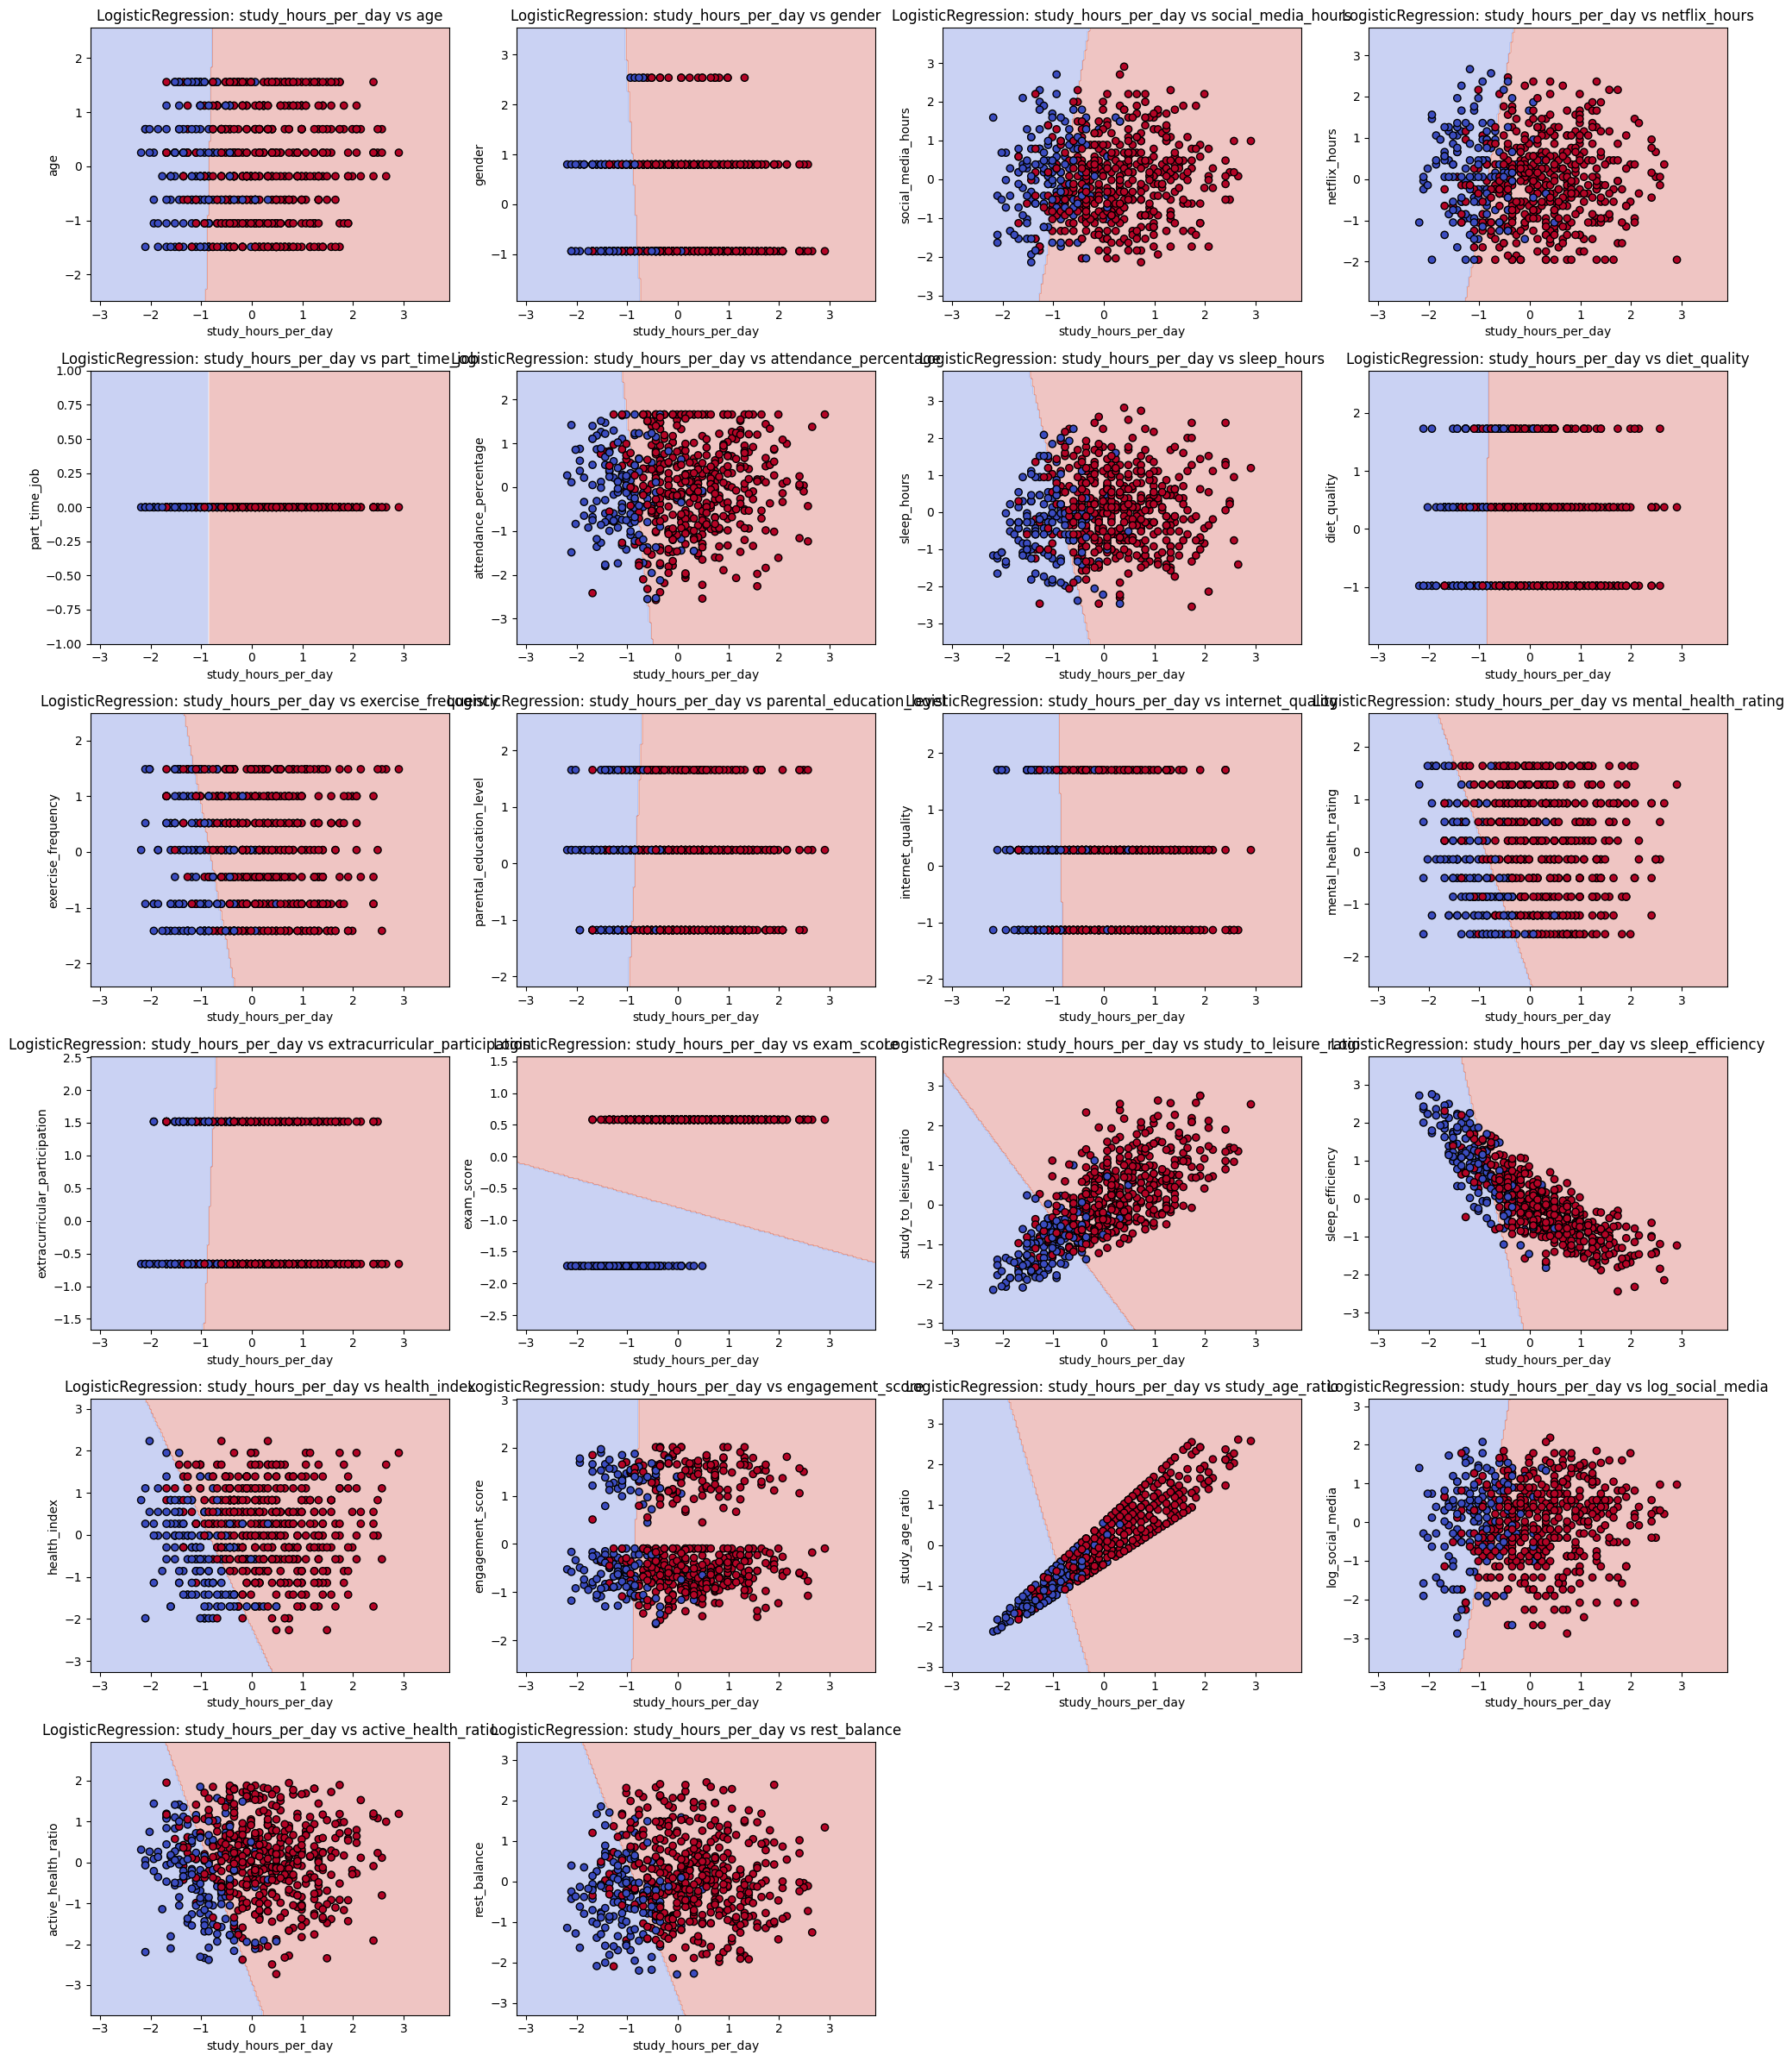

In [611]:
plot_fixed_feature_decision_surface(
    df=df_lin,
    target_col='target_class',
    model=model_logreg,
    fixed_feature='study_hours_per_day',
    n_cols=4
)

### 4.1 Обучение и тесты моделей \{Desicion Tree, Random Forest\}

In [612]:
# Список моделей
models = {
    "DesicionTree": model_tree,
    "RandomForest": model_forest
}

test_models_pipeline(df_raw, target_col='exam_score', models_dict=models, n_splits=5, random_state=RANDOM_STATE)

=== DesicionTree ===
Accuracy: 0.863 ± 0.022
F1-score: 0.905 ± 0.016
ROC-AUC: 0.832 ± 0.023
=== RandomForest ===
Accuracy: 0.910 ± 0.018
F1-score: 0.938 ± 0.012
ROC-AUC: 0.961 ± 0.010


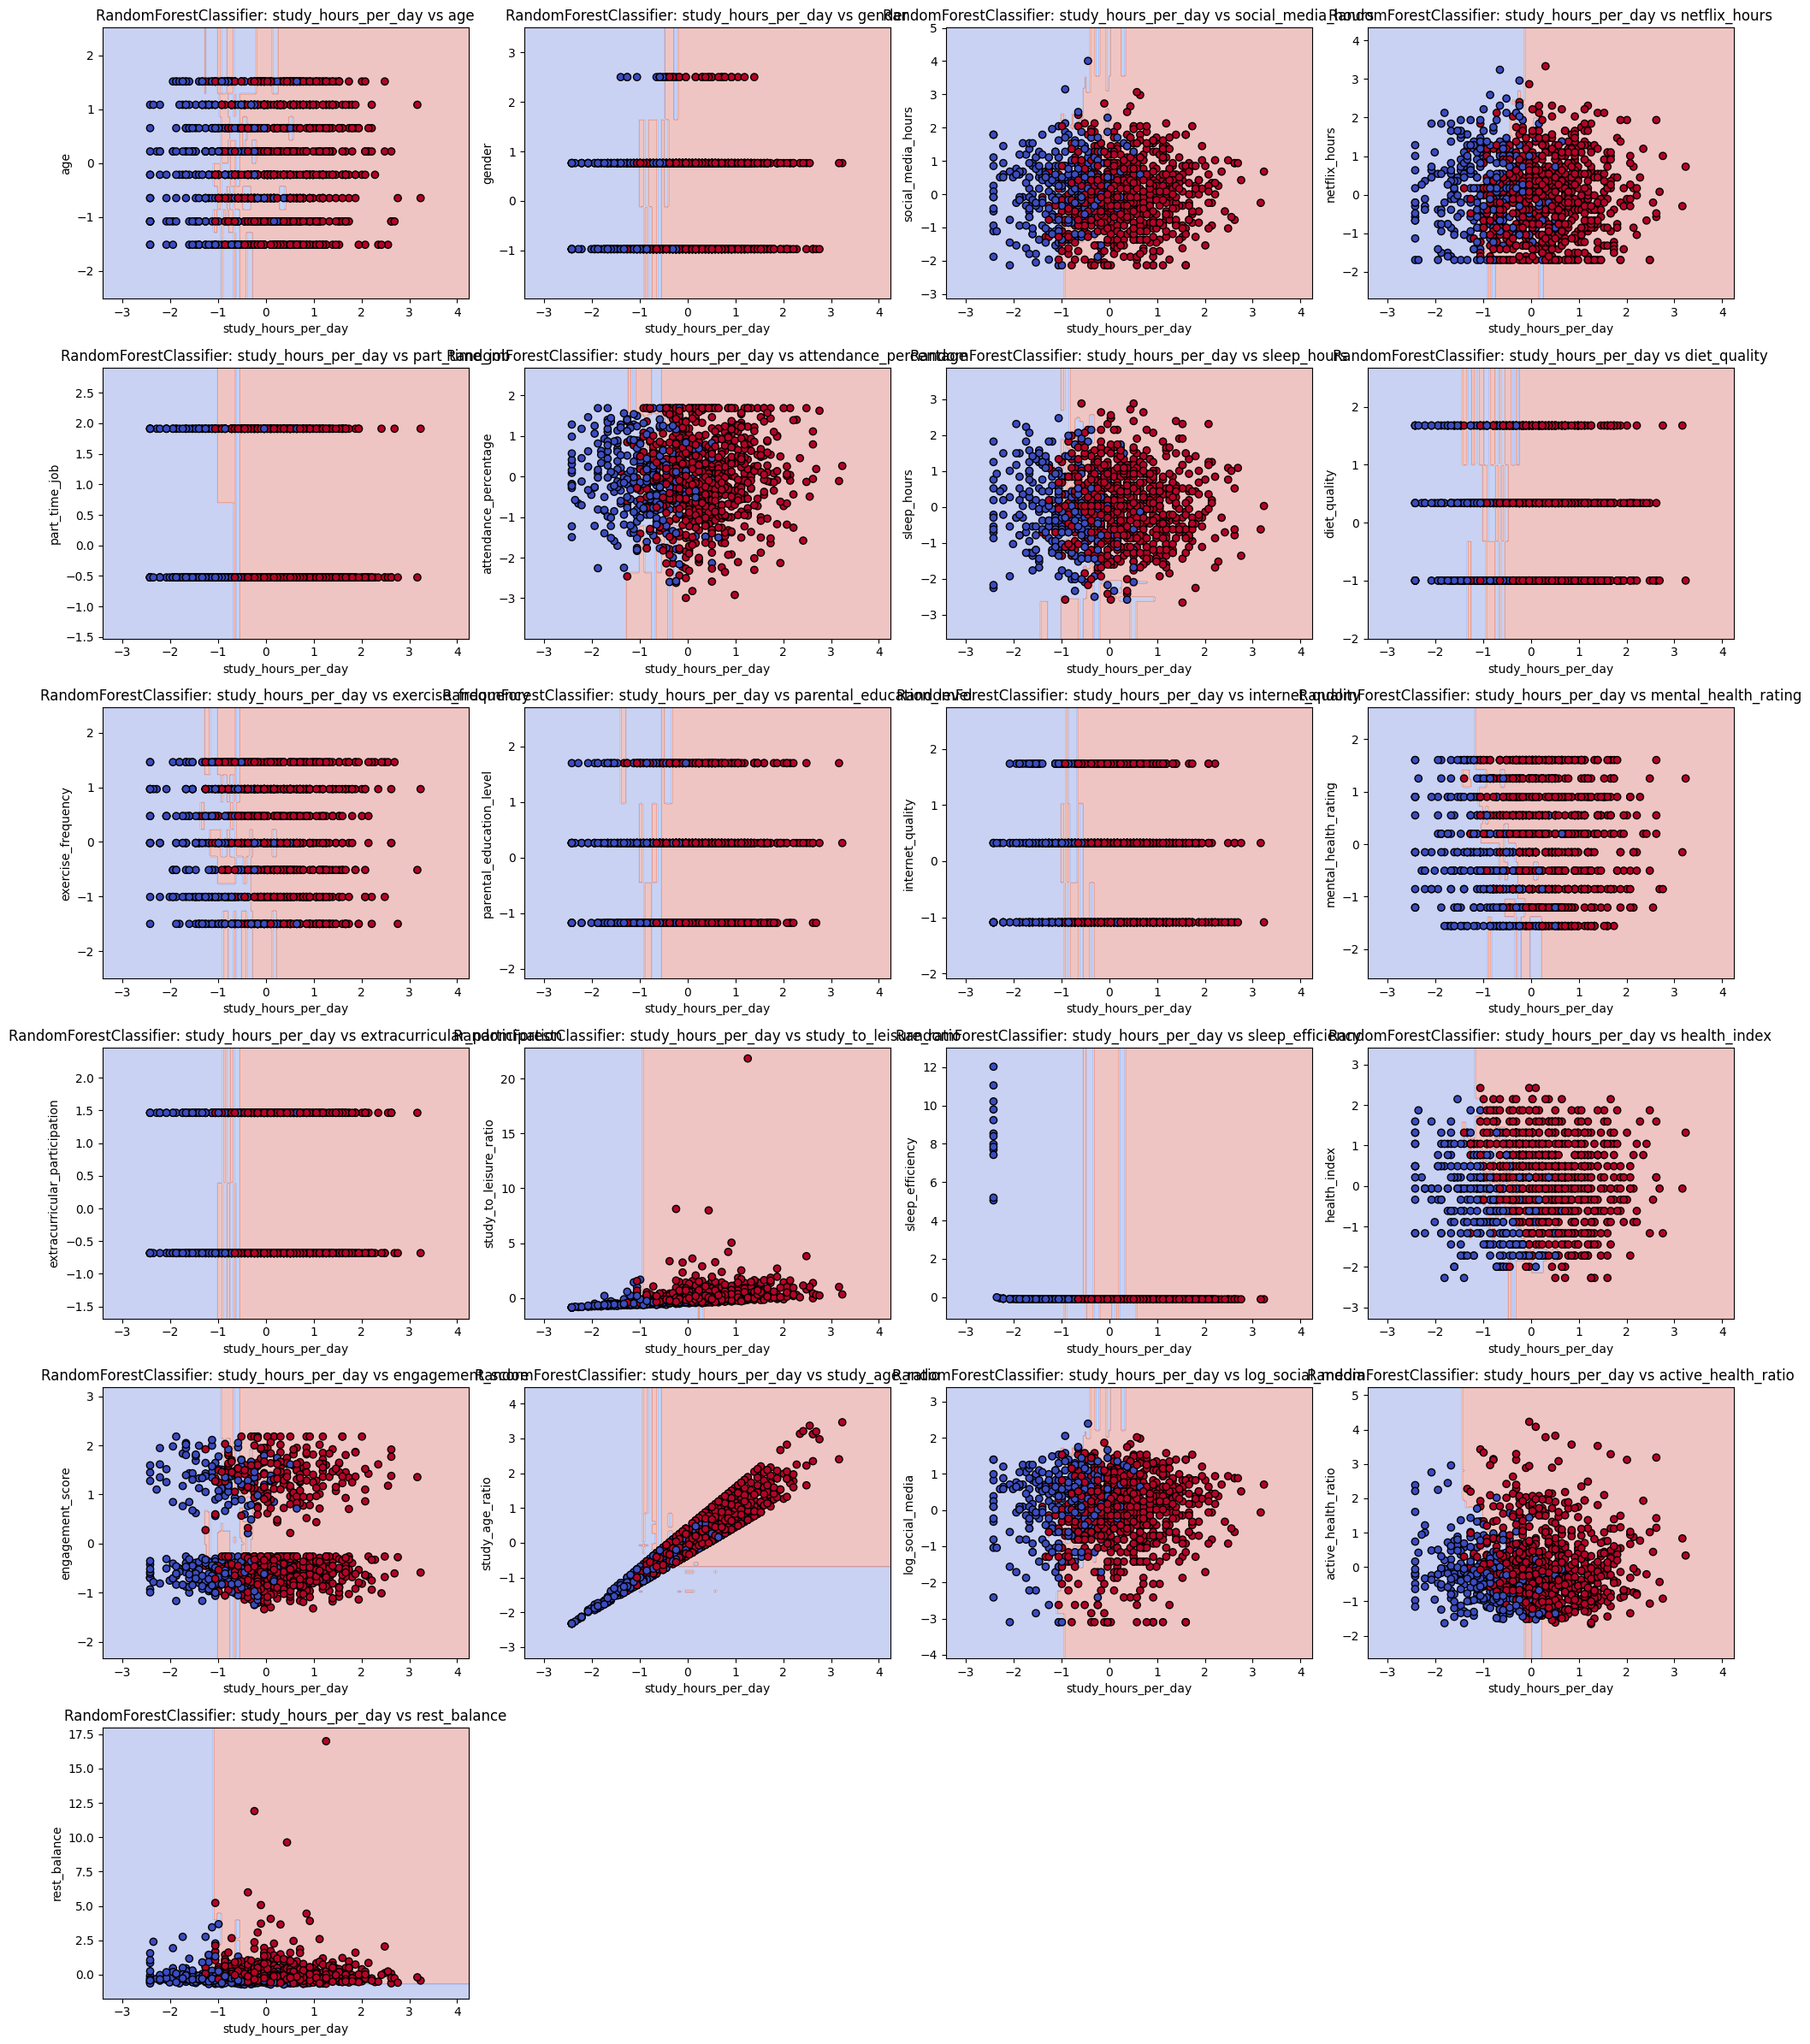

In [613]:
plot_fixed_feature_decision_surface(
    df=df_raw,
    target_col='exam_score',
    model=model_forest,
    fixed_feature='study_hours_per_day',
    n_cols=4
)

### 4.2 Обучение и тесты моделей \{Boosting Classifier, XGBoost, CatBoost\}

In [614]:
# Список моделей
models = {
    "Boosting": model_gb,
    "XGBoost": model_xgb,
    "CatBoost": model_cat
}

test_models_pipeline(df_raw, target_col='exam_score', models_dict=models, n_splits=5, random_state=RANDOM_STATE)

=== Boosting ===
Accuracy: 0.904 ± 0.021
F1-score: 0.935 ± 0.015
ROC-AUC: 0.960 ± 0.013
=== XGBoost ===
Accuracy: 0.903 ± 0.026
F1-score: 0.934 ± 0.018
ROC-AUC: 0.961 ± 0.013
=== CatBoost ===
Accuracy: 0.908 ± 0.019
F1-score: 0.937 ± 0.013
ROC-AUC: 0.962 ± 0.011


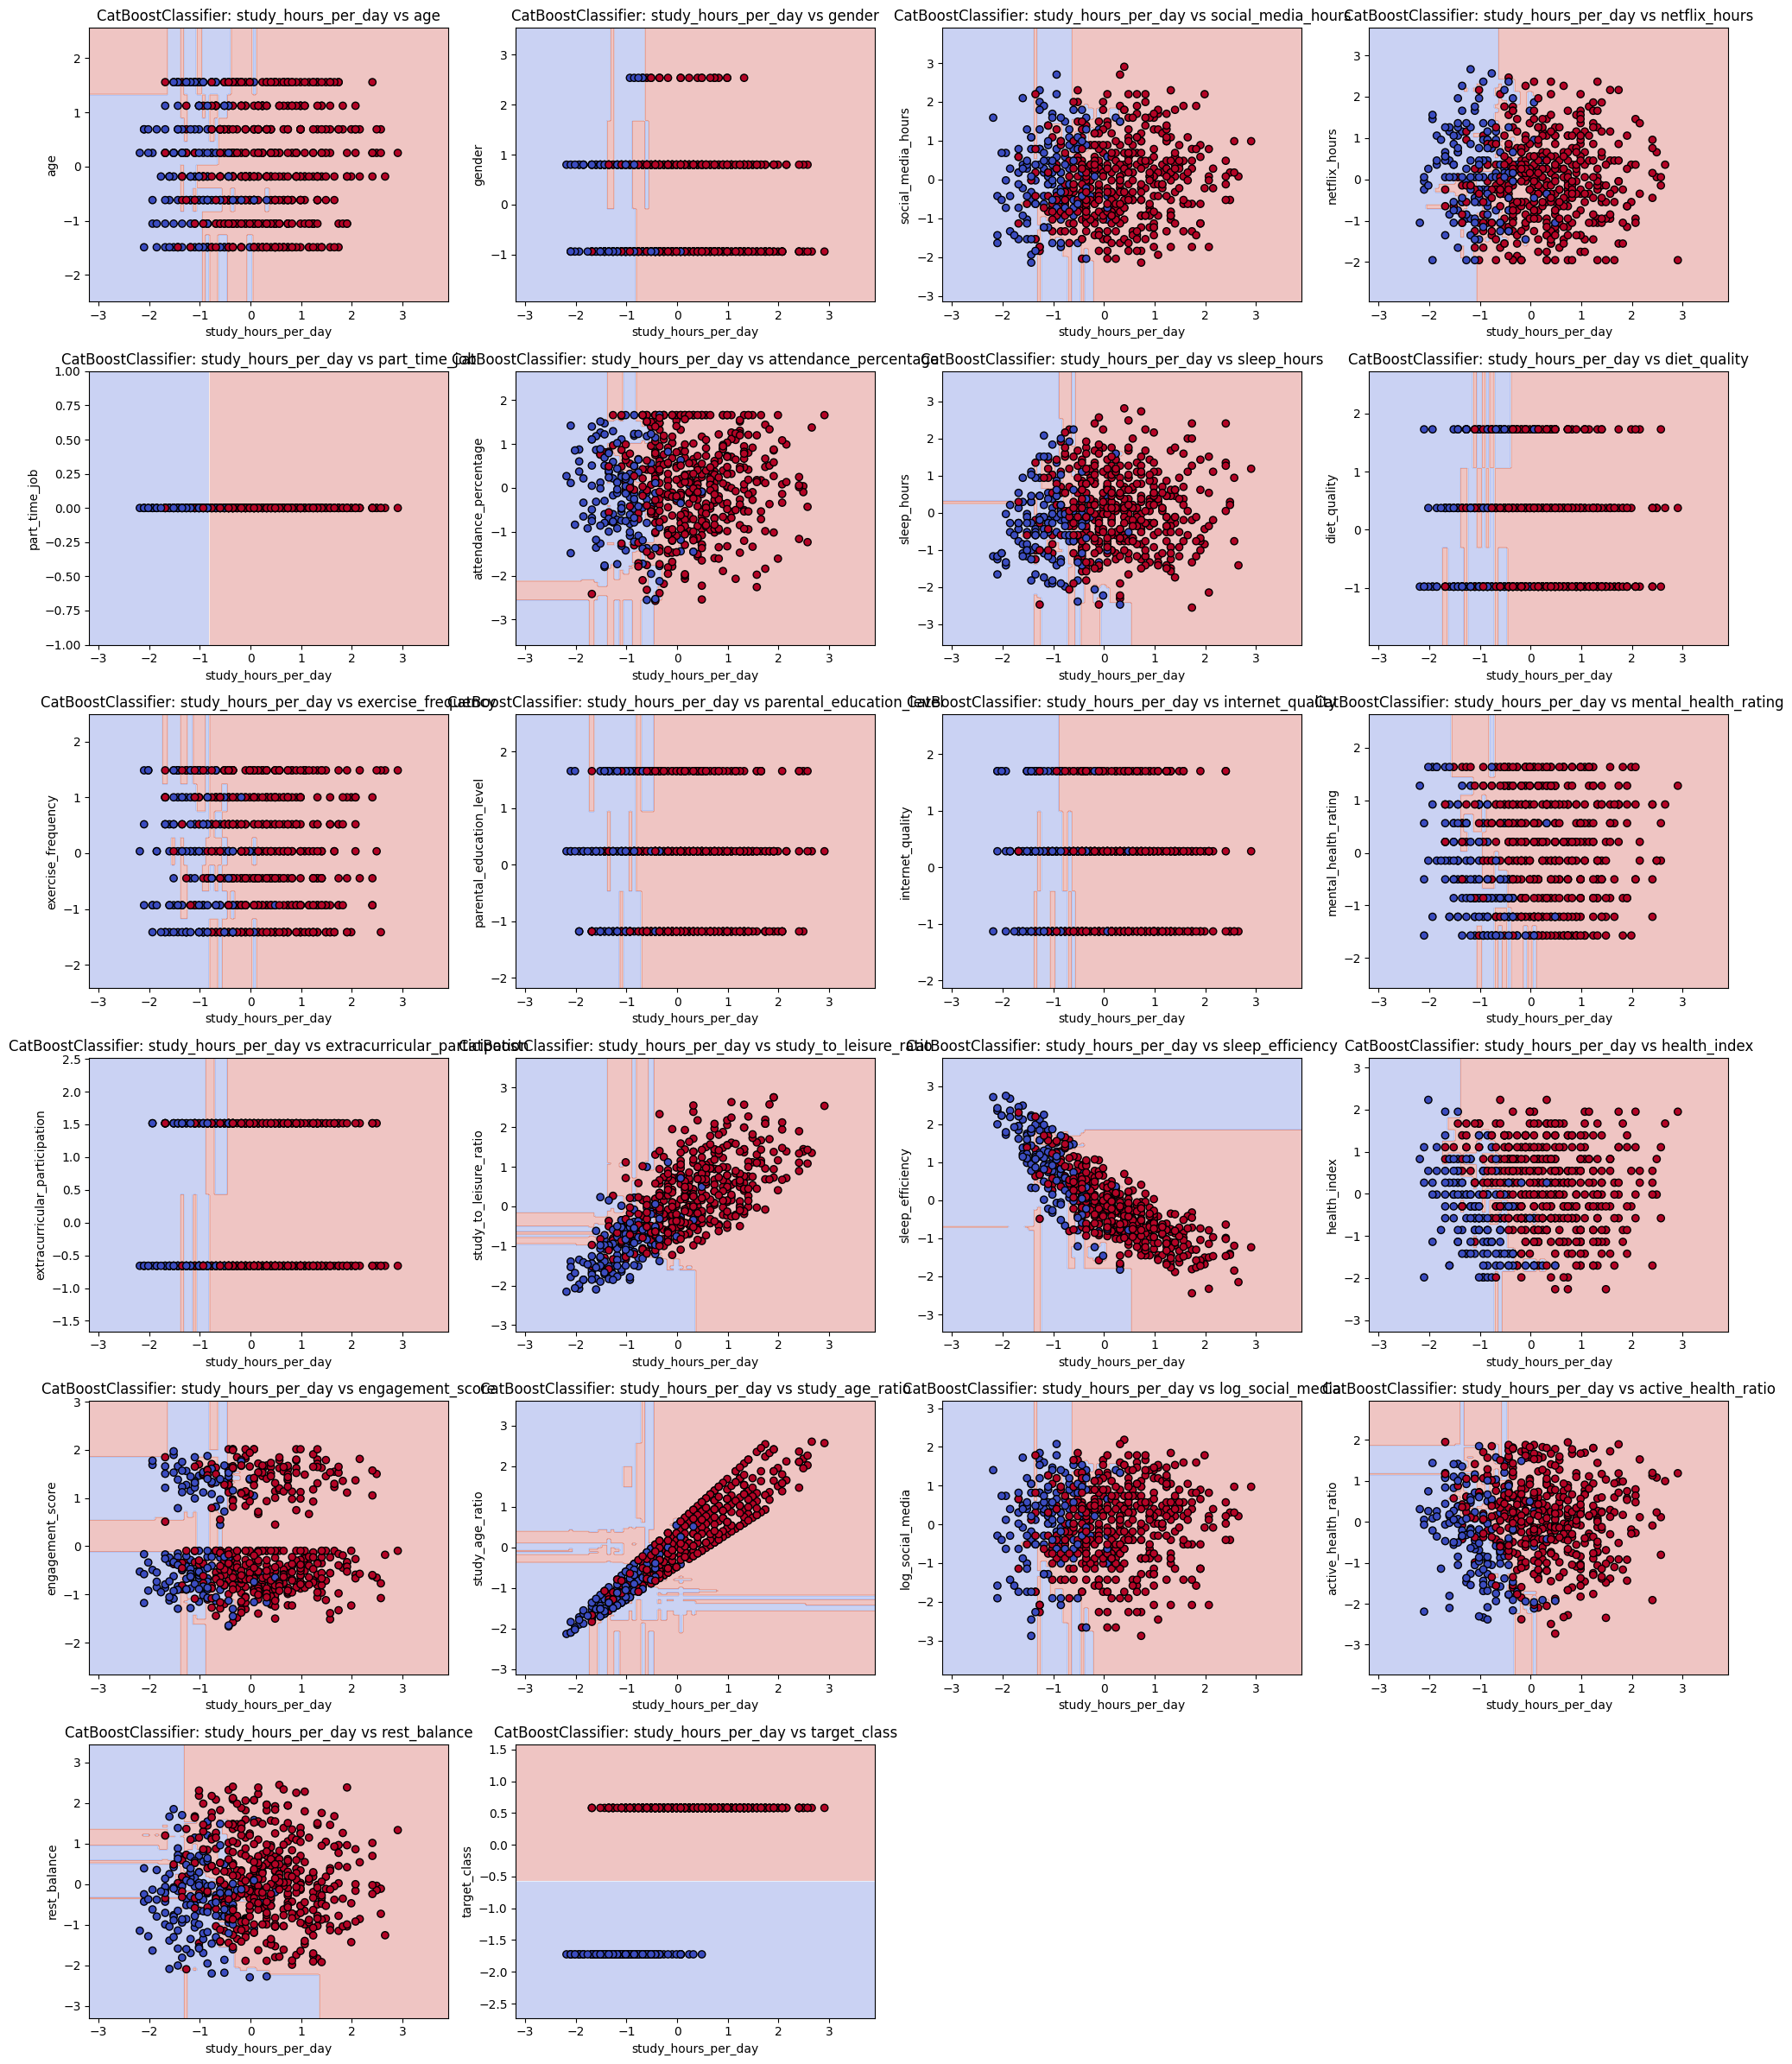

In [615]:
plot_fixed_feature_decision_surface(
    df=df_lin,
    target_col='exam_score',
    model=model_cat,
    fixed_feature='study_hours_per_day',
    n_cols=4
)

## Фича

Калькулятор

In [ ]:
import numpy as np

print("Калькулятор вероятности сдачи экзамена (XGBoost)")
print("=" * 60)

# Ввод данных
try:
    age  = float(input("  Возраст (лет): "))
    gender = int(input("  Пол (0=жен, 1=муж): "))

    study_hours_per_day = float(input("  Учебные часы в день: "))
    social_media_hours  = float(input("  Часы в соцсетях в день: "))
    netflix_hours       = float(input("  Часы видео/Netflix в день: "))

    part_time_job = int(input("  Подработка (0/1): "))
    attendance_percentage = float(input("  Посещаемость (%) 0..100: "))
    sleep_hours = float(input("  Сон (часов в день): "))

    diet_quality = int(input("  Качество питания (0=низк,1=средн,2=высок): "))
    exercise_frequency = float(input("  Тренировки (раз/нед): "))
    parental_education_level = int(input("  Образование родителей (0=низк,1=средн,2=высш): "))
    internet_quality = int(input("  Качество интернета (0=низк,1=средн,2=высок): "))

    mental_health_rating = float(input("  Психическое здоровье (1..10): "))
    extracurricular_participation = int(input("  Внеучебная активность (0/1): "))

except Exception as e:
    print(f"Ошибка: {e}")
    raise

# Генерация всех признаков
eps = 1e-6
study_to_leisure_ratio = study_hours_per_day / (social_media_hours + netflix_hours + eps)
sleep_efficiency       = sleep_hours / (study_hours_per_day + 1.0)
health_index           = (exercise_frequency + diet_quality + mental_health_rating) / 3.0
engagement_score       = attendance_percentage * (1 + extracurricular_participation)
study_age_ratio        = study_hours_per_day / (age + eps)
log_social_media_hours = np.log(social_media_hours + 1.0)
active_health_ratio    = exercise_frequency / (sleep_hours + eps)
rest_balance           = sleep_hours / (study_hours_per_day + exercise_frequency + eps)

# Формируем вектор в порядке колоночек df_raw 
FEATURES = [c for c in df_raw.columns if c != "exam_score"]

vals = {
    # базовые:
    "age": age,
    "gender": gender,
    "study_hours_per_day": study_hours_per_day,
    "social_media_hours": social_media_hours,
    "netflix_hours": netflix_hours,
    "part_time_job": part_time_job,
    "attendance_percentage": attendance_percentage,
    "sleep_hours": sleep_hours,
    "diet_quality": diet_quality,
    "exercise_frequency": exercise_frequency,
    "parental_education_level": parental_education_level,
    "internet_quality": internet_quality,
    "mental_health_rating": mental_health_rating,
    "extracurricular_participation": extracurricular_participation,

    # engineered:
    "study_to_leisure_ratio": study_to_leisure_ratio,
    "sleep_efficiency":       sleep_efficiency,
    "health_index":           health_index,
    "engagement_score":       engagement_score,
    "study_age_ratio":        study_age_ratio,
    "log_social_media_hours": log_social_media_hours,
    "active_health_ratio":    active_health_ratio,
    "rest_balance":           rest_balance,
}

X_input = np.array([[vals.get(col, 0.0) for col in FEATURES]], dtype=float)

# Предсказание
prob = model_xgb.predict_proba(X_input)[0]   # [P(0), P(1)]
pred = model_xgb.predict(X_input)[0]         # 0/1

# Результат
print(f"Вероятность что не сдаст: {prob[0]:.1%}")
print(f"Вероятность что    сдаст: {prob[1]:.1%}")
print(f"\nПРЕДСКАЗАНИЕ: **{'СТУДЕНТ СДАСТ' if pred == 1 else 'СТУДЕНТ НЕ СДАСТ'}**")


Калькулятор вероятности сдачи экзамена (XGBoost)
РЕЗУЛЬТАТ ПРЕДСКАЗАНИЯ
Вероятность НЕ СДАСТ: 0.6%
Вероятность    СДАСТ: 99.4%

ПРЕДСКАЗАНИЕ: **СТУДЕНТ СДАСТ**


## 5. Вопросы

**1. Классификация писем: спам или не спам**

**Вопрос:**
У нас есть набор писем, для каждого известны признаки:

* количество восклицательных знаков,
* доля заглавных букв,
* наличие слов вроде “free”, “win”, “discount”,
* длина письма,
* наличие ссылок.

Задача — определить, является ли письмо **спамом** или **нормальным**.

**Распределение данных:**

* Данные нелинейно разделимы, но умеренно шумные.
* Классы примерно сбалансированы (50/50).

**Ответ:**

- **Модель:**

```
SVM
```

- **Почему:**

```
SVM с RBF-ядром хорошо подходит для нелинейно разделимых данных, а в задаче указано, что признаки сложно разделимы линейной границей. SVM устойчив к шуму, эффективно работает при сбалансированных классах и малом/среднем количестве признаков, что соответствует условиям задачи.
```

**2. Прогноз сердечных заболеваний**

**Вопрос:**
Данные о пациентах:

* возраст, пол, давление, уровень холестерина, частота сердечных сокращений,
* наличие боли в груди и др.

Задача — определить, есть ли у человека сердечное заболевание.

**Распределение данных:**

* Классы умеренно сбалансированы (60/40).
* Признаки имеют нелинейные зависимости.

**Ответ:**

- **Модель:**

```
Случайный лес (Random Forest)
```

- **Почему:**

```
Random Forest хорошо работает с нелинейными зависимостями между признаками, устойчив к шуму и не требует масштабирования признаков. Он способен выявлять сложные комбинации факторов риска, у него встроенная оценка важности признаков, а moderate class imbalance (60/40) не мешает его работе. Модель легко интерпретировать и она часто эффективна на медицинских данных такого типа.
```

**3. Распознавание видов ирисов (Iris dataset)**

**Вопрос:**
По измерениям длины и ширины лепестков и чашелистиков нужно определить вид ириса:
`setosa`, `versicolor` или `virginica`.

**Распределение данных:**

* Данные чистые, малошумные.
* Классы хорошо разделяются в пространстве признаков.

**Ответ:**

- **Модель:**

```
Логистическая регрессия (Logistic Regression) либо метод k ближайших соседей (kNN)
```

- **Почему:**

```
Данные чистые, малошумные и классы хорошо разделяются в пространстве признаков. Для таких условий подойдут простые интерпретируемые модели: логистическая регрессия эффективно разделяет классы при линейной разделимости, а kNN отлично справляется с хорошо разделёнными кластерами. Обе модели быстро обучаются и обеспечивают высокую точность на классическом датасете ирисов.
```

**6. Классификация отзывов о фильмах (положительный / отрицательный)**

**Вопрос:**
Для каждого отзыва по фильму дан текст. Нужно определить, положительный он или отрицательный.
Используются текстовые признаки — мешок слов (TF-IDF).

**Распределение данных:**

* Очень высокое число признаков (10k+ слов).
* Данные разреженные.

**Ответ:**

- **Модель:**

```
Логистическая регрессия (Logistic Regression) или линейный SVM

```

- **Почему:**

```
Обе модели хорошо работают с большими, разреженными и высокоразмерными признаками, получаемыми из TF-IDF. Они интерпретируемы, быстро обучаются, устойчивы к переобучению при большом числе признаков, не требуют сильного тюнинга и часто показывают отличные результаты на задачах текстовой классификации.
```
